### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.lines as mlines
from phik import phik_matrix
import warnings
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from scipy.stats import chi2_contingency, fisher_exact
import pandas as pd

from strokegraphfunctions import (
    plot_numerical_boxplots,
    plot_numerical_distributions_with_mean,
    plot_categorical_distributions,
    plot_binary_distributions,
    plot_violinplots_numerical_by_stroke,
    plot_countplots_categorical_by_stroke,
    plot_stroke_rate_by_category,
    plot_stripplot_by_stroke,
    plot_binary_strip_and_countplot_rate,
    plot_pearson_correlation_heatmap,
    plot_phik_heatmap,
    plot_median_differences,
    plot_odds_ratios,
)

from pipeline_stroke_functions import pipeline_stroke, evaluate_pipeline

from pipeline_stroke_selected_features_functions import (
    pipeline_stroke_selected_features,
    evaluate_pipeline_selected_features,
    pipeline_stroke_selected_features_smote_tomek,
    evaluate_pipeline_selected_features_smotetomek,
)

warnings.filterwarnings("ignore")

# Stroke Risk Prediction Model: Johns Hopkins Hospital

## Introduction

### Background

In this project I will explore dataset designed to identify stroke risk in patients. Stroke is a major global health concern, ranking as the second leading cause of death worldwide. It is also a leading cause of disability. Annually, millions experience strokes, and a significant number of these result in death. After data exploration and analysis, I will build, train and deploy a model which could predict whether patients is likely to have stroke or not, based on parameters like age, gender, lifestyle choices, bmi and so on. 

### Problem

It’s hard to spot which patients are at high risk of stroke, making it tough to catch it early and prevent it.

### Goal

To build a model that helps doctors spot patients at higher risk of stroke early so they can take action and help prevent deaths.

### Hypotheses

4 hypotheses I want to explore:

1. Older age increases likelyhood of stroke.
- **H₀:** Age is not associated with stroke risk.
- **H₁:** Increasing age is associated with higher stroke risk

2. Males are more likely to have a stroke than females.
- **H₀:** Gender has no effect on stroke risk.
- **H₁:** Male patients have a higher probability of experiencing a stroke than female patients.

3. Obesity increases risk of a stroke.
- **H₀:** BMI is not associated with stroke risk.
- **H₁:** Higher BMI is associated with an increased likelihood of stroke.

4. Having a hypertension increases chances of having a stroke
- **H₀:** Hypertension is not associated with stroke risk.
- **H₁:** Patients with hypertension have higher odds of experiencing a stroke.

### Scope

The analysis scope includes :

- Data cleaning and preparation.
- Descriptive analysis of patient demographics and health indicators.
- Formulation and testing of clear, interpretable hypotheses about risk factors.
- Development of various  models to predict stroke likelihood.
- Deployment of model with best performance.

The project is limited to the variables available in the provided dataset and does not incorporate external medical records or real-time clinical data. The findings are intended for educational and exploratory purposes and do not replace professional medical advice.

### Evaluation Metrics

**Main Evaluation Metrics:** 

- Recall (Class 1). Measures the ability to correctly indentify true stroke cases.

- Macro F1 Score. Balances precision and recall across classes to ensure fair assesment of performance on both stroke and non-strokes case in an imbalanced dataset.


**Secondary Evaluation Metric:**
- Precision (Class 1). It tells how many of positive predictions were actually correct.

- Confusion Matrix. Provides detailed breakdown of correct and incorrect predictions.

## Data Overview and Splitting

### Data Source and Loading the Data

Data source is Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

Loading the data and making a copy of it:

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df = data.copy()

### Feature Definitions

- **id**: Unique patient identifier (integer).  
- **gender**: Patient gender (Male, Female, or Other).  
- **age**: Patient age in years (float).  
- **hypertension**: Binary indicator of hypertension (0 = No, 1 = Yes).  
- **heart_disease**: Binary indicator of heart disease (0 = No, 1 = Yes).  
- **ever_married**: Marital status (Yes/No).  
- **work_type**: Type of employment (e.g., Private, Self-employed, Govt_job, Children, Never_worked).  
- **Residence_type**: Urban or Rural residence.  
- **avg_glucose_level**: Average blood glucose level (float).  
- **bmi**: Body Mass Index (float).
- **smoking_status**: Smoking status (Never smoked, Formerly smoked, Smokes, Unknown).  
- **stroke**: Target variable indicating stroke occurrence (0 = No, 1 = Yes).

### General Data Overview

Checking the columns:

In [4]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

The ID column is unnecessary and provides no value, I can drop it:

In [5]:
df.drop(columns=["id"], inplace=True)

Checking the shape of the dataset:

In [6]:
df.shape

(5110, 11)

Previewing the tail of the data set:

In [7]:
df.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


**Interpretation:** Sample data shows varied patient details with some missing BMI values and cathegorical features needing encoding.

In [8]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**Interpretation:** 

- Numerical features show wide ranges: age spans from infancy to 82, average glucose levels and BMI have high variability.

- Stroke prevalence is low, about 5%, suggesting that there's class imbalance.

- Again confirmed that BMI has missing values.

### Splitting the Data

I will split data early to avoid data leakage.

Defining features and target:

In [9]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

I will filter out Other gender before splitting, because it has only 1 entry:

In [10]:
X = X[X["gender"] != "Other"]
y = y.loc[X.index]

First split: Train + Temp

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

Second split: Validation + Test

In [12]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

Confirming shapes:

In [13]:
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Testing set size:", X_test.shape)

Training set size: (3065, 10)
Validation set size: (1022, 10)
Testing set size: (1022, 10)


**Interpretation:** Data set has been split to three parts: 60% Training, 20% Validation, 20% Test. Stratify ensures original imbalances stays in all three parts.

## Data Cleaning (Training Data)

Checking columns:

In [14]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

Lowering all capital letters for consistency:

In [15]:
df.columns = df.columns.str.lower()

Checking for duplicates:

In [16]:
df.duplicated().sum()

np.int64(0)

Confirming missing values:

In [17]:
df.isnull().sum().sum()

np.int64(201)

In [18]:
df[df["bmi"].isnull()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


**Interpretation:** Exploration shows BMI is more often missing in older, higher-risk patients. To reduce bias, median imputation within age groups will be applied instead of single global median.

Exploring the youngest stroke case:

In [19]:
min_age_with_stroke = df[df["stroke"] == 1]["age"].min()
print(f"Youngest age with stroke: {min_age_with_stroke}")

Youngest age with stroke: 1.32


Showing all stroke cases under 18:


In [20]:
stroke_under_18 = df[(df["stroke"] == 1) & (df["age"] < 18)]
print("All stroke cases with age < 20:")
print(stroke_under_18)

All stroke cases with age < 20:
     gender    age  hypertension  heart_disease ever_married work_type  \
162  Female   1.32             0              0           No  children   
245  Female  14.00             0              0           No  children   

    residence_type  avg_glucose_level   bmi smoking_status  stroke  
162          Urban              70.37   NaN        Unknown       1  
245          Rural              57.93  30.9        Unknown       1  


There are only 2 stroke cases under 18. I will leave them as it can be not an error, but real life accurances, because:

- Strokes in children and teenagers (including 14-year-olds) can happen, but they are uncommon.

- Babies can have perinatal or pediatric strokes, even before birth or in the first year of life.

Binning age into groups:

In [21]:
age_bins = [0, 18, 39, 59, 64, 120]
age_labels = [
    "Under 18",
    "Young Adult",
    "Middle-Aged Adult",
    "Senior Adult",
    "Elderly",
]

Creating age_group column:

In [22]:
df["age_group"] = pd.cut(
    df["age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True
)

Imputing BMI withing age groups:

In [23]:
df["bmi"] = df.groupby("age_group", observed=False)["bmi"].transform(
    lambda x: x.fillna(x.median())
)

Confirming the change:

In [24]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group'],
      dtype='object')

Confirming there no missing values left:

In [25]:
df.isnull().sum().sum()

np.int64(0)

**Interpretation:** 

- Age was binned into clinically meaningful groups and new column of age group was created. 

- Missing BMI values were impurted using the median BMI withing each age group to reduce bias and reflect age-specific health profiles.

Checking distribution of genders:

In [26]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Since there is only 1 record of Other gender, I will delete it since it gives me not enough data to learn patterns:

In [27]:
df = df[df["gender"].isin(["Male", "Female"])]

Confirming changes:

In [28]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

Checking the amount of 'Unknown' answer in Smoking column:

In [29]:
print(df["smoking_status"].value_counts(dropna=False))

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


It's 2nd largest answer group and it's not empty value, so I will treat it as separate category.

### Outliers

Defining numerical columns:

In [30]:
num_cols = ["age", "avg_glucose_level", "bmi"]

Visualizing it in a boxplots:

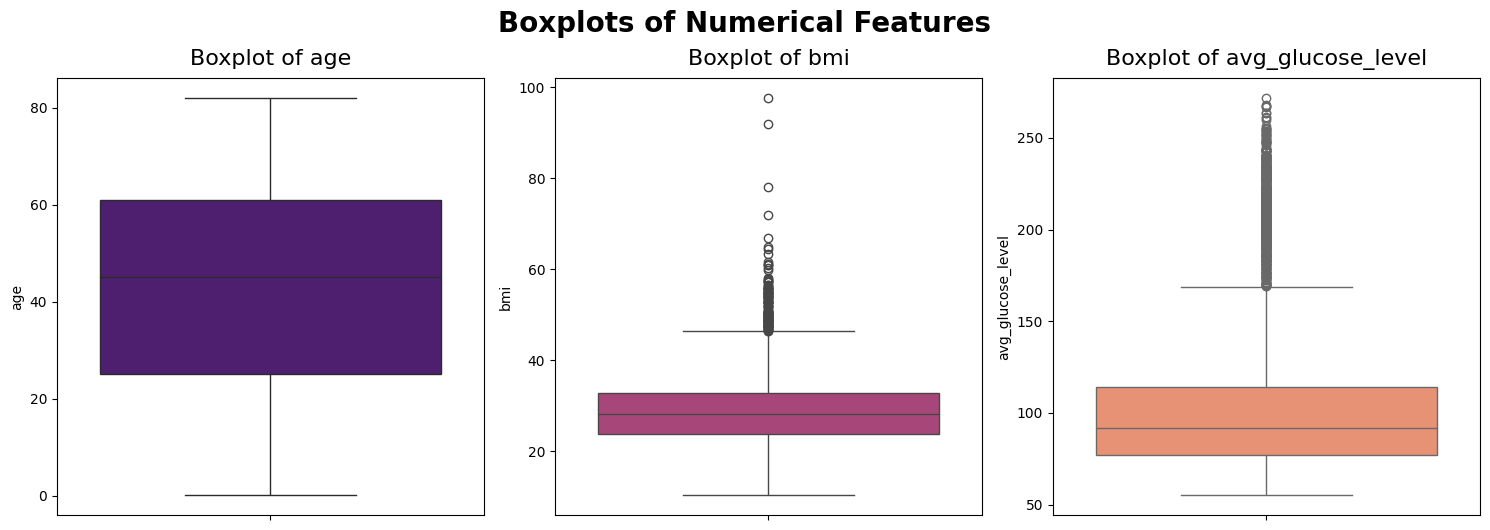

In [31]:
plot_numerical_boxplots(df=df, num_cols=["age", "bmi", "avg_glucose_level"])

**Interpretation:** 

- Age feature does not have extreme outliers, 

- BMI and average glucose level has some way higher values than usual, which could be considerable outliers. 

- BMI >60–70 is possible but extremely rare.

- Avg glucose has extreme high outliers (250+)








Logging average glucose values:

In [32]:
df["avg_glucose_level_log"] = np.log(df["avg_glucose_level"])

Capping BMI:

In [33]:
upper_limit_bmi = df["bmi"].quantile(0.99)
df["bmi_capped"] = np.where(df["bmi"] > upper_limit_bmi, upper_limit_bmi, df["bmi"])

In [34]:
num_cols_cleaned = ["age", "bmi_capped", "avg_glucose_level_log"]

Confirming columns:

In [35]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'avg_glucose_level_log',
       'bmi_capped'],
      dtype='object')

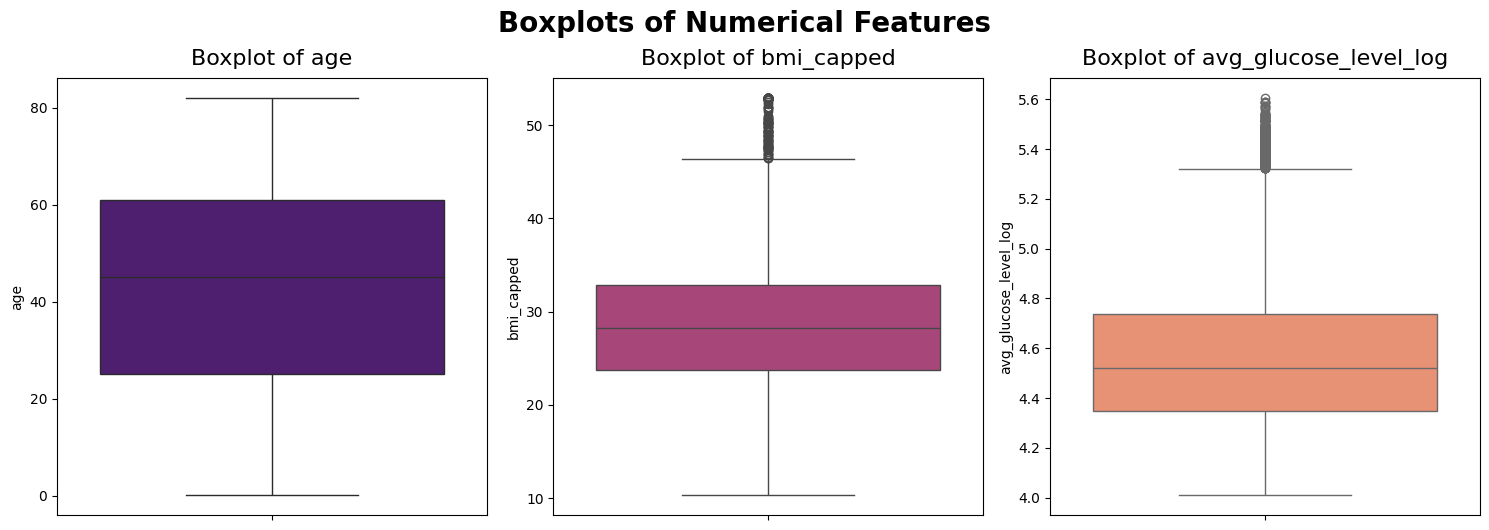

In [36]:
plot_numerical_boxplots(df, ["age", "bmi_capped", "avg_glucose_level_log"])

**Interpretation:** 

- Outliers successfully dealt with. 

- BMI was capped at 99% percentile limit to lower the influence of extreme outliers and preserve interprebility.

- To preserve relative difference avg_glucose values were logged to reduce skewness.

## EDA: Univariate Analysis

### Numerical Variables Distribution

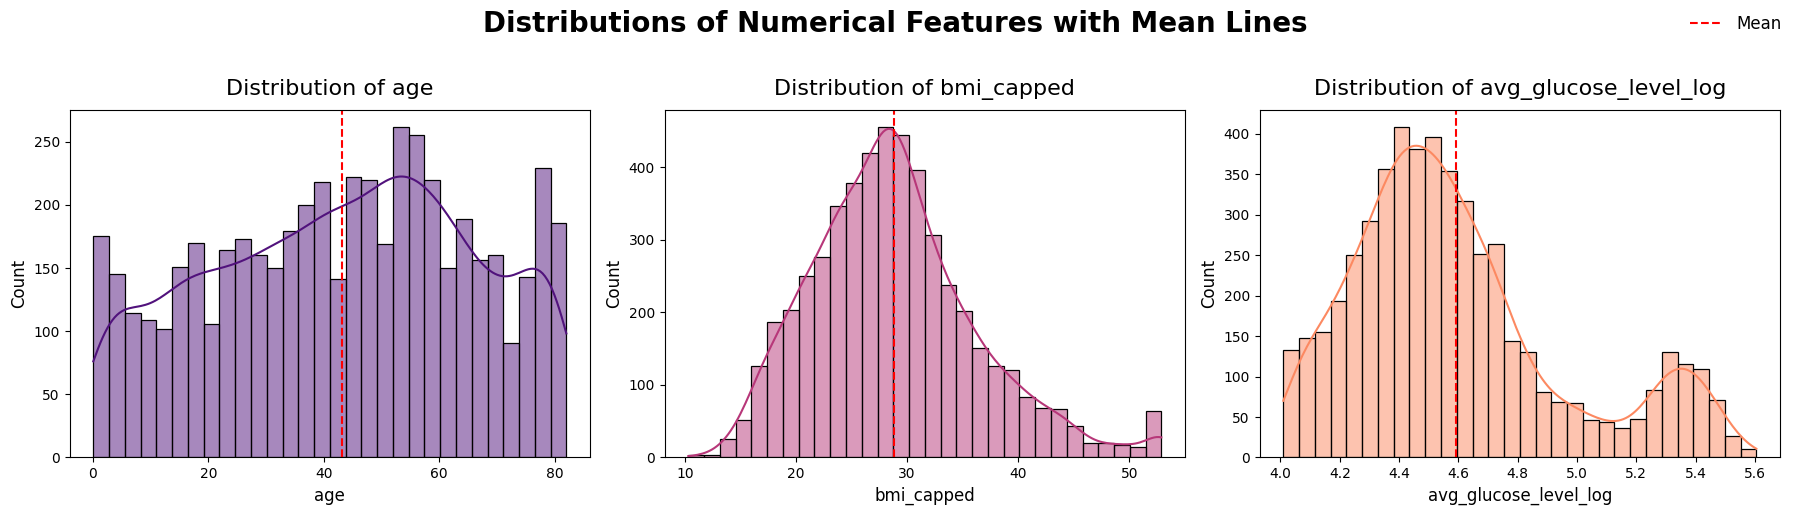

In [37]:
plot_numerical_distributions_with_mean(df, num_cols_cleaned)

**Interpretation:**

- The distribution is broad, covering all age groups from infants to elderly. The typical age of people in this dataset is around 43.
- Avg_glucose_level_log ≈ 4.45 which translates to roughly ~84 mg/dL which is normal glucose level. Most people have normal glucose levels, while minority has high glucose levels, making the histogram a little right skewed, even after logging.
- The typical BMI in this dataset is about 29, in the overweight range. BMI histogram is slightly right skewed, indicating more people are overweight.


### Cathegorical Variables Distribution

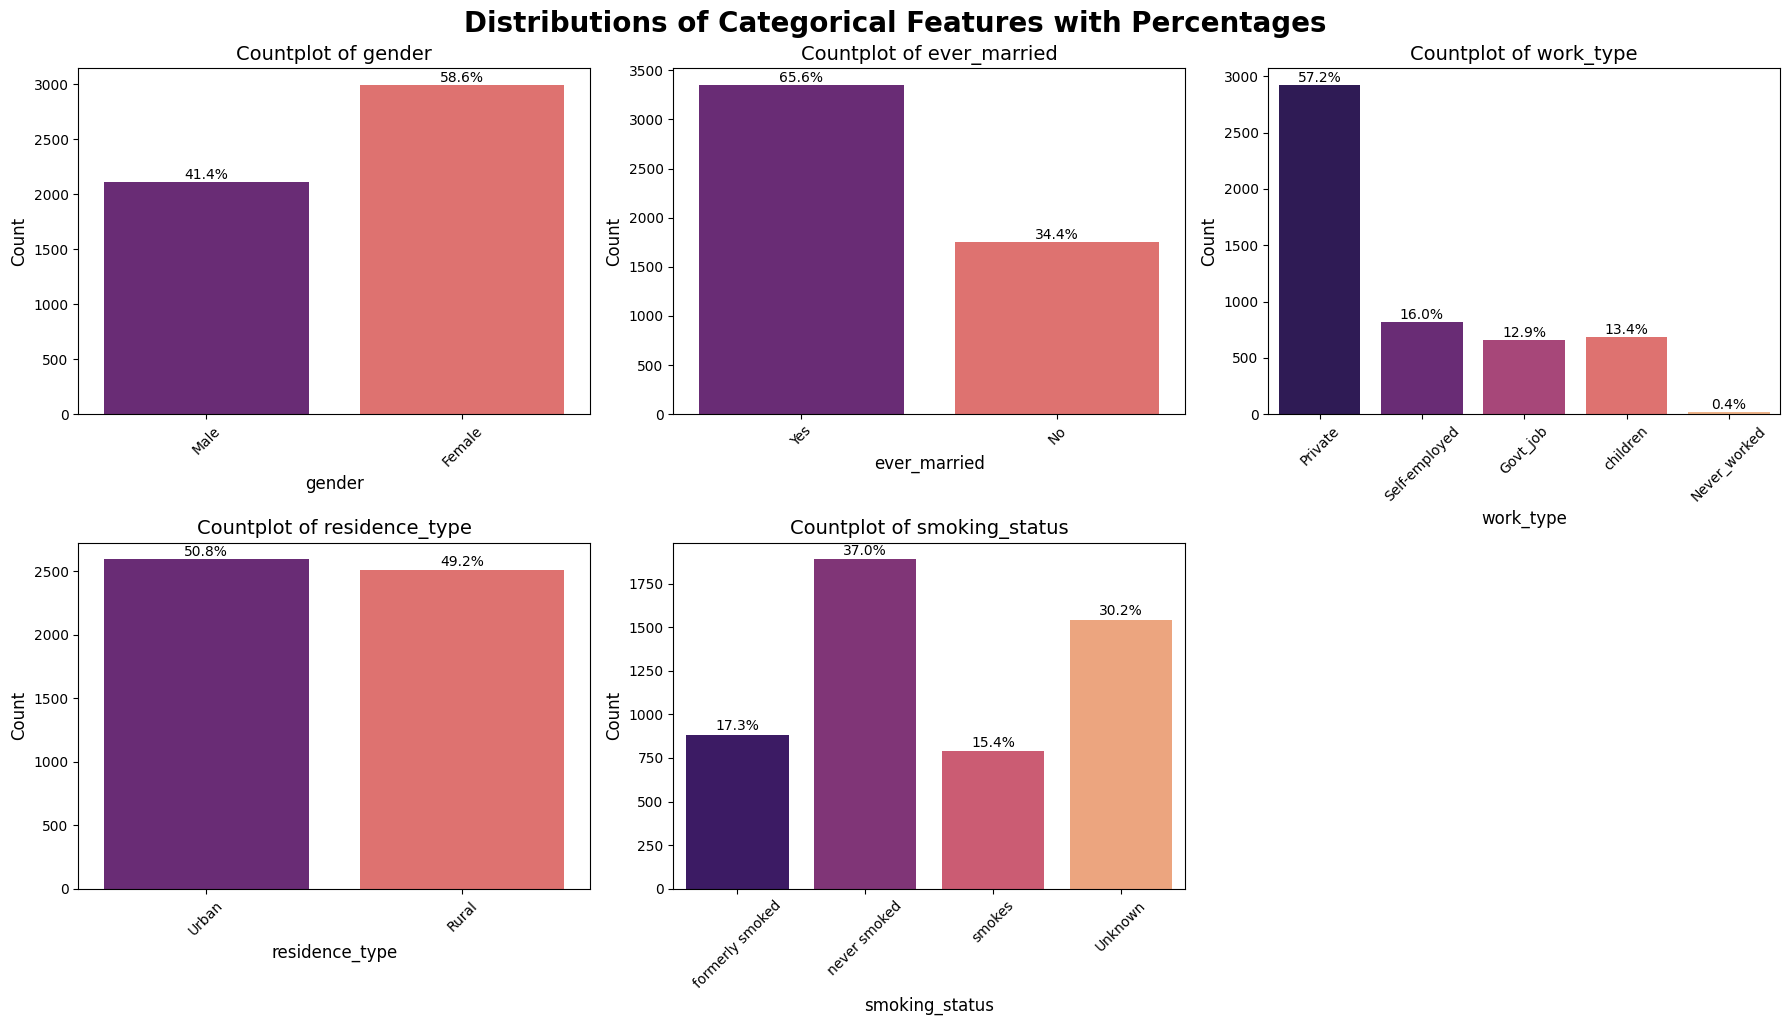

In [38]:
cat_cols = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]
plot_categorical_distributions(df, cat_cols)

**Interpretation:** 

- Gender and residence type are balanced.
- Most patients are married and work in the private sector.
- Never-smoked is the most popular group in smoking status category.

### Binary Features Distribution

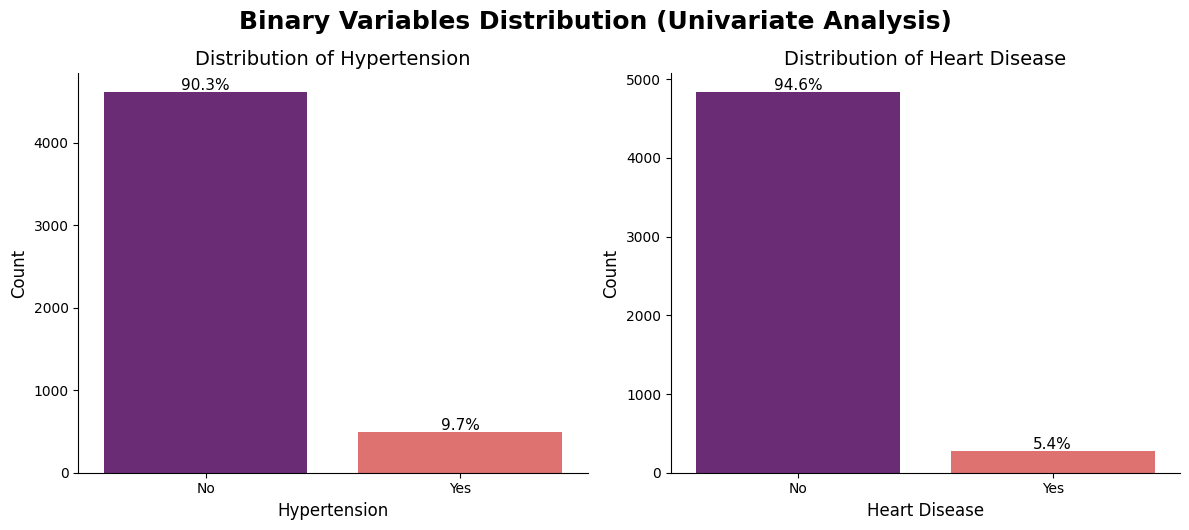

In [39]:
binary_cols = ["hypertension", "heart_disease"]
plot_binary_distributions(df, binary_cols)

**Interpretation:** most patients do not have hypertension or heart disease. Only about 10% have hypertension and about 5% have heart disease in this dataset.

## EDA: Bivariate Analysis

### Numerical Features vs Stroke Status

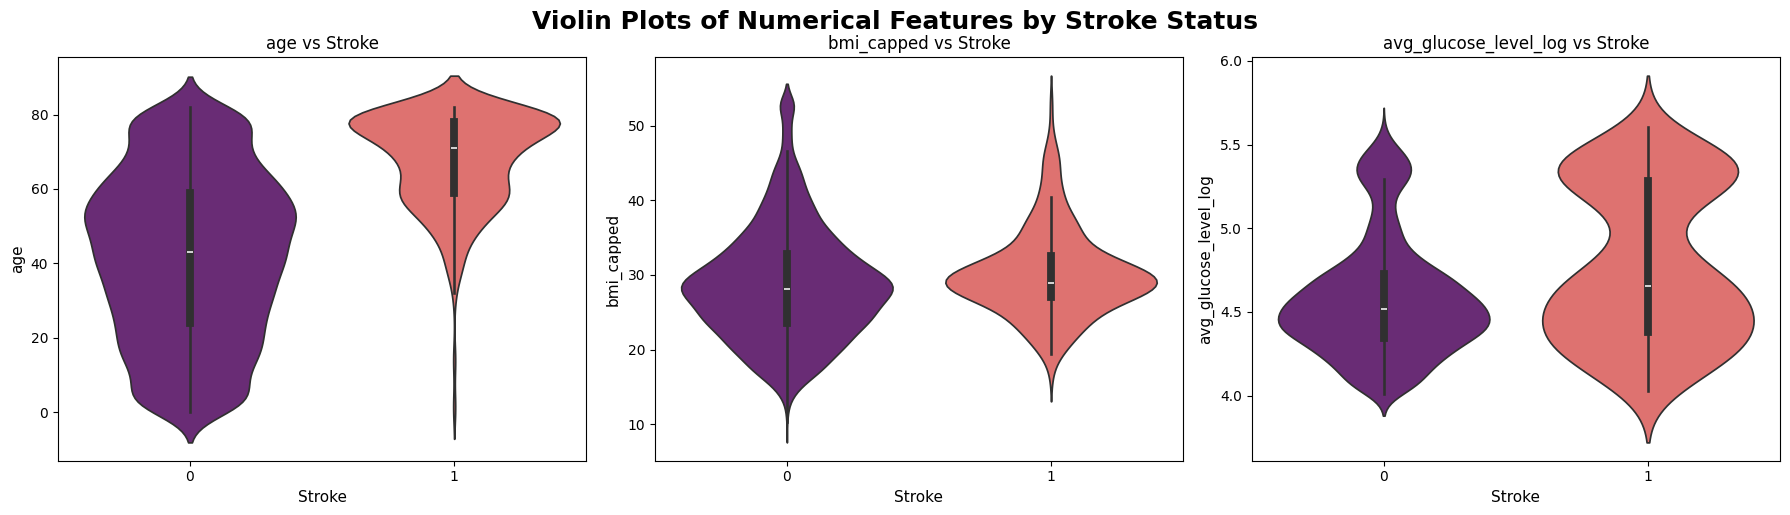

In [40]:
plot_violinplots_numerical_by_stroke(df, num_cols_cleaned)

**Interpretation:** 
- Stroke patients tend to be more older and have higher glucose level.
- BMI appears similar with slight differences.

**Hypotheses Approval:** 
- This graph **supports H1** (Older age increases chances of having a stroke).
- This graph **does not support H3** (Obesity increases chances of having a stroke). The difference is too small.

### Categorical Features vs Stroke Status

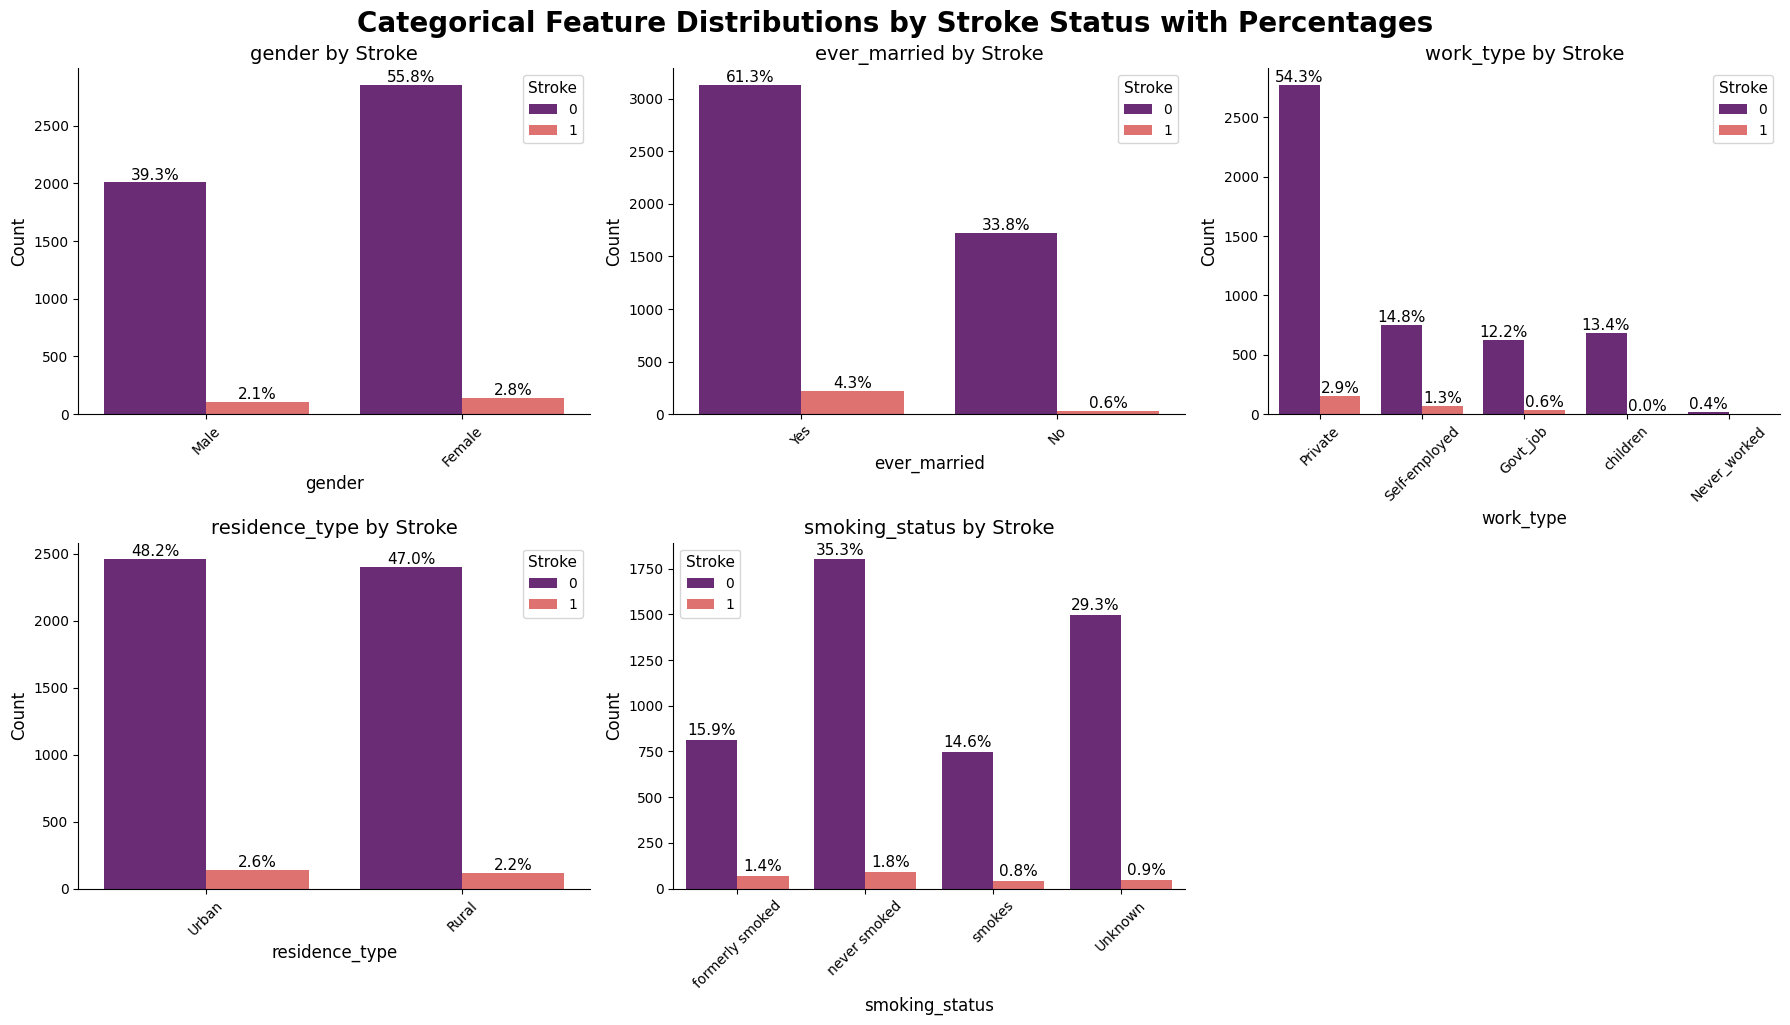

In [41]:
cat_cols = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]
plot_countplots_categorical_by_stroke(df, cat_cols)

**Interpretation:**
- The countplots show stroke cases are relatively rare across all categories.
- Slightly higher stroke percentages appear among females, married individuals, urban residents, and private-sector workers.
- Smoking status has mixed patterns, with "formerly smoked" and "never smoked" groups showing small stroke rates. 







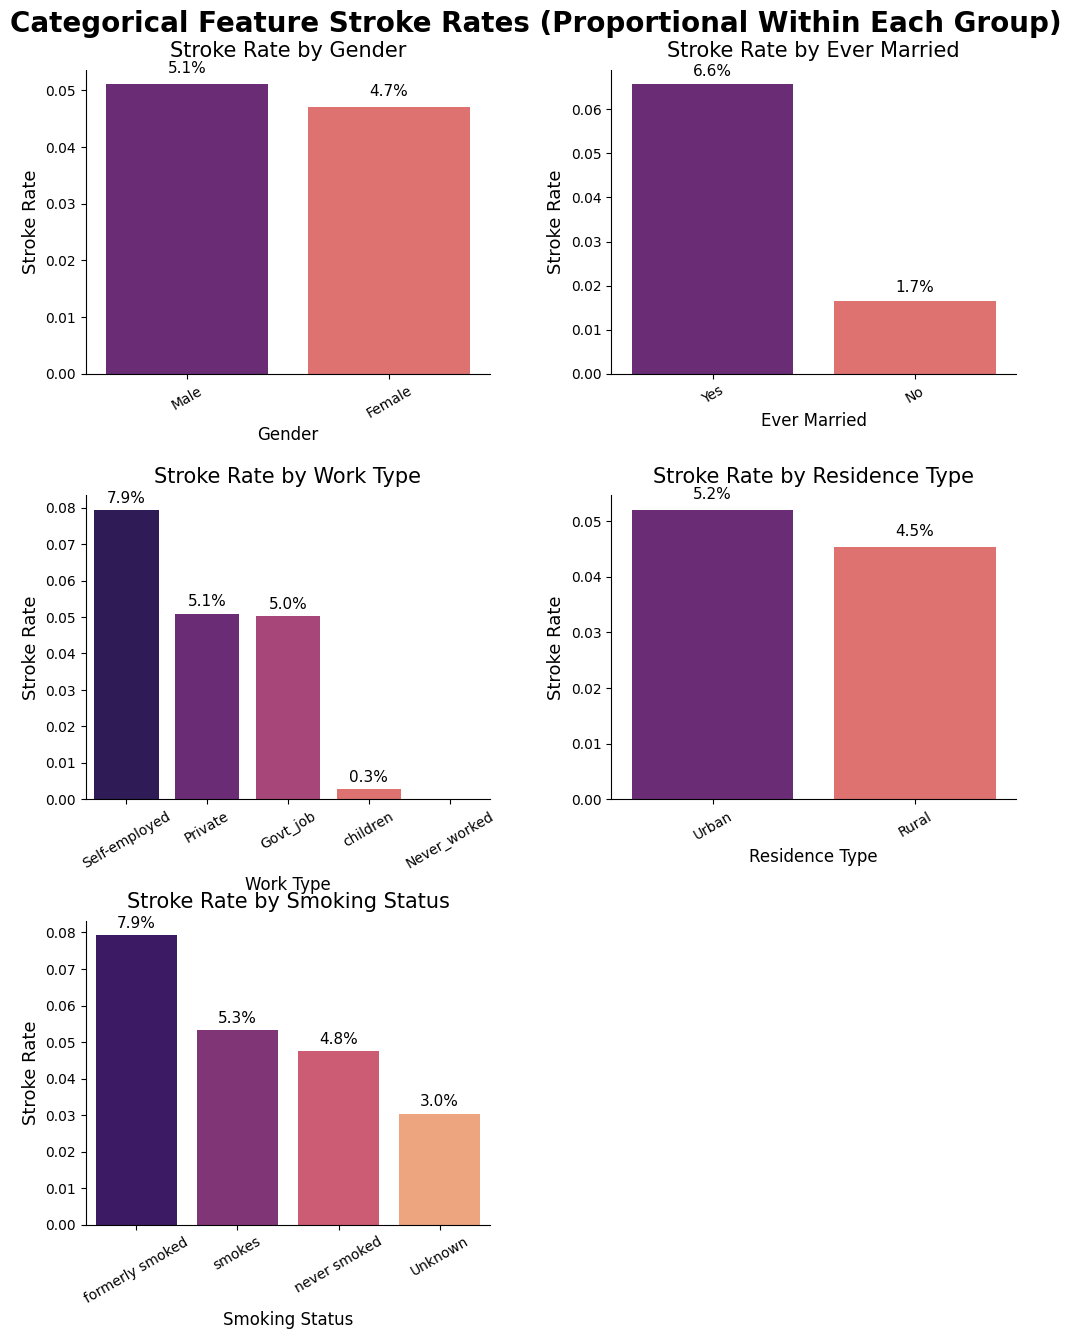

In [42]:
plot_stroke_rate_by_category(df, cat_cols, target_col="stroke")

**Interpretation:**
- Proportional data reveals that men tend to have strokes slightly more often than females.
- Married people more than three times are more likely to have a stroke.
- Self-employed workers have the highest risk of having a stroke.
- Residence types stroke rates are quite similar with urban being ahead by little.
- Former smokers suffers from strokes most commonly.

**Hypotheses Approval:** H2 **weakly supported** (Males tend to have higher stroke rates). Stroke risk is slightly higher in males than females in this dataset.


### Age Groups by Stroke Status

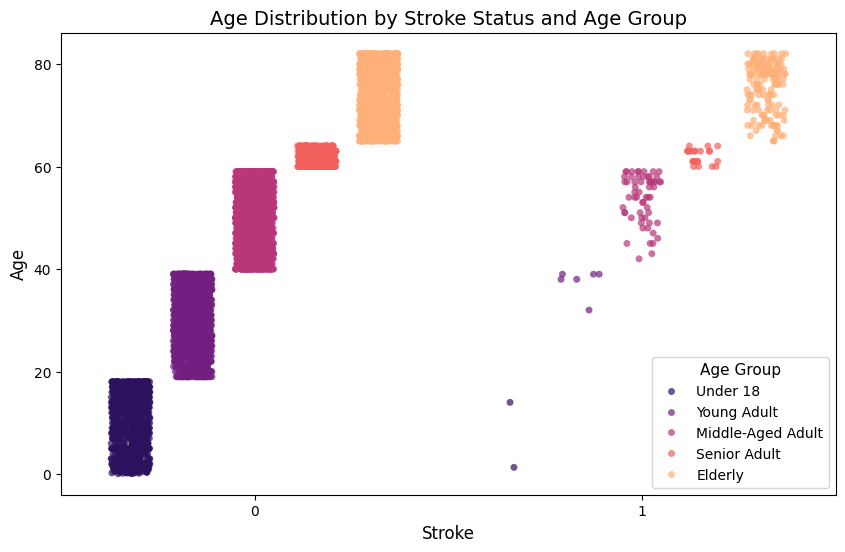

In [43]:
plot_stripplot_by_stroke(
    df,
    numerical_col="age",
    target_col="stroke",
    hue_col="age_group",
    legend_loc="lower right",
    title="Age Distribution by Stroke Status and Age Group",
)

**Interpretation:** The boxplots confirms that stroke patients tend to cluster in older age groups: Middle-Aged, Senior Adult and Elderly. Younger groups have very few cases.

**Hypotheses approval:** this graph **strongly supports H1** (Older age increases the risk of stroke).

### Binary Features by Stroke

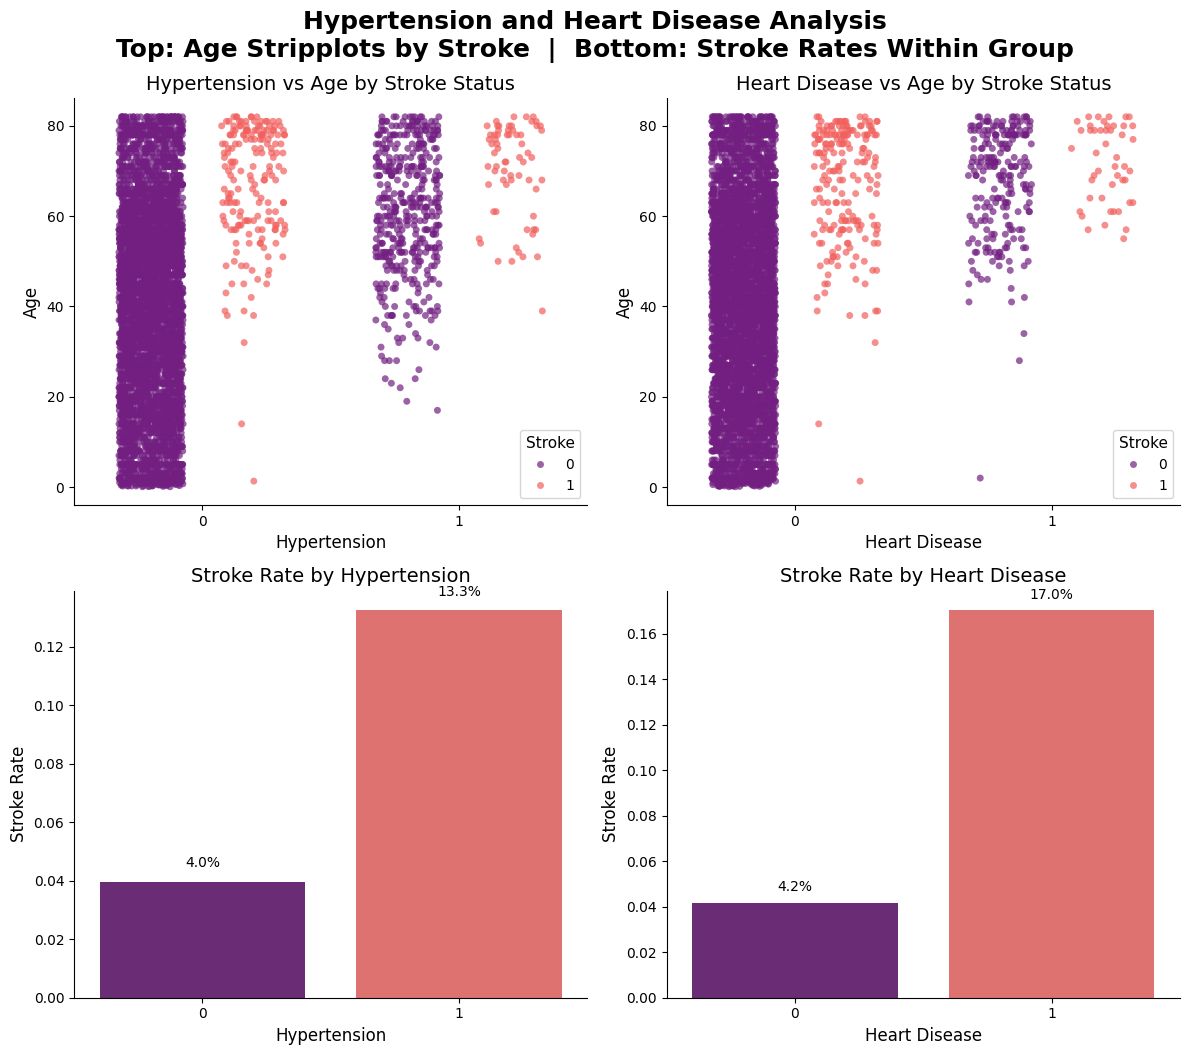

In [44]:
# Define binary columns
binary_cols = ["hypertension", "heart_disease"]
palette = sns.color_palette("magma", n_colors=2)

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# TOP ROW: Stripplots of raw individual data by stroke
for i, col in enumerate(binary_cols):
    ax = axes[0, i]
    sns.stripplot(
        x=col,
        y="age",
        data=df,
        hue="stroke",
        dodge=True,
        jitter=0.25,
        alpha=0.7,
        palette=palette,
        ax=ax,
    )
    ax.set_title(
        f"{col.replace('_', ' ').title()} vs Age by Stroke Status", fontsize=14
    )
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Age", fontsize=12)
    ax.legend(title="Stroke", fontsize=10, title_fontsize=11)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# BOTTOM ROW: Stroke rate within each binary group (barplots)
for i, col in enumerate(binary_cols):
    ax = axes[1, i]

    prop_df = (
        df.groupby(col)["stroke"]
        .mean()
        .reset_index()
        .rename(columns={"stroke": "Stroke Rate"})
    )
    sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
    ax.set_title(f"Stroke Rate by {col.replace('_', ' ').title()}", fontsize=14)
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Stroke Rate", fontsize=12)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + 0.005,
                f"{height*100:.1f}%",
                ha="center",
                fontsize=10,
            )

plt.tight_layout()
plt.suptitle(
    "Hypertension and Heart Disease Analysis\nTop: Age Stripplots by Stroke  |  Bottom: Stroke Rates Within Group",
    fontsize=18,
    weight="bold",
    y=1.05,
)
plt.show()

**Interpretation:** 
-  Stroke cases are much more frequent at older ages, regardless of hypertension or heart disease, but Hypertension/Heart disease + Older age together increase risk even more.
- Countplots show that stroke cases are proportionally more common among patients with hypertension and heart disease, but rate is still quite relatively low (around 13% Hypertension, around 17% Heart Disease)

**Hypothesis approval:** 

- H1 **supported** (Older age increases risk of stroke).

- This graph **supports H4** (Having a hypertension increases chances of having a stroke). Stroke rate among hypertensives is about 3x higher.

## EDA: Correlation

### Pearson Correlation

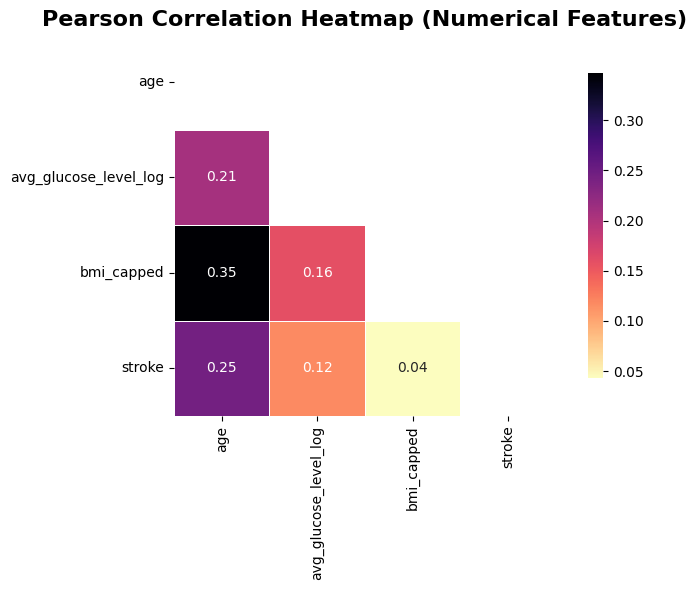

In [45]:
numerical_cols = ["age", "avg_glucose_level_log", "bmi_capped", "stroke"]
plot_pearson_correlation_heatmap(df, numerical_cols)

**Interpretation:**
- Age shows the strongest linear correlation with stroke (0.25), suggesting older patients are more likely to have a stroke.

- BMI (0.04) and glucose (0.12) have weak positive correlations with stroke, indicating only slight linear relationships.

- Age and BMI has strongest correlation (0.35) from all the numerical features.

### Phi-K Correlation

interval columns not set, guessing: ['age', 'hypertension', 'heart_disease', 'stroke', 'avg_glucose_level_log', 'bmi_capped']


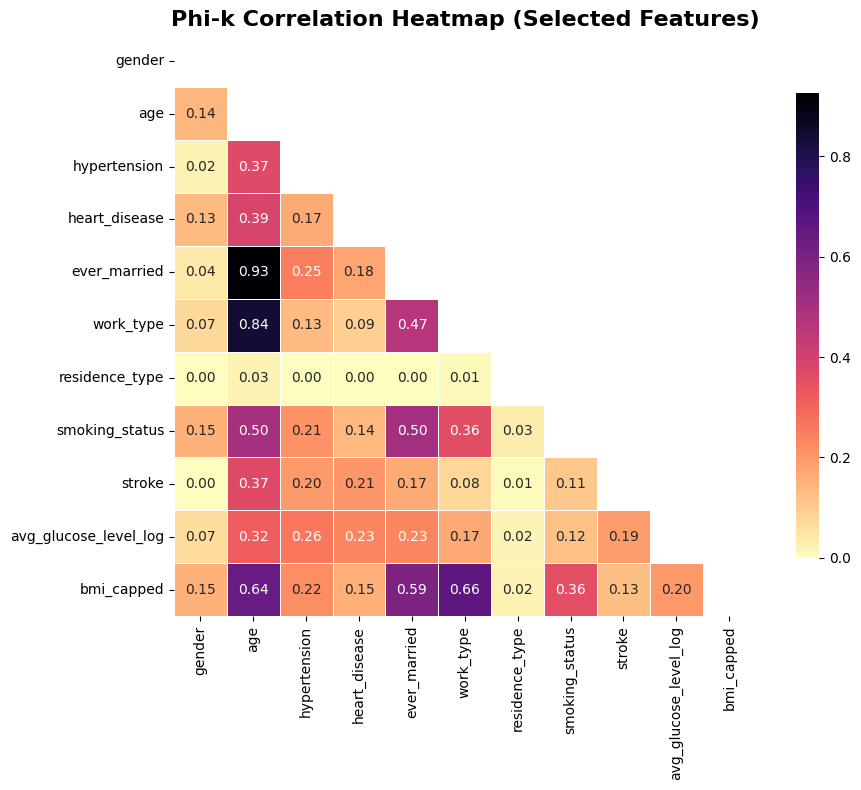

In [46]:
plot_phik_heatmap(df, exclude_cols=["bmi", "age_group", "avg_glucose_level"])

**Interpretation:** 
- Stroke shows the strongest associations with age (0.37), hypertension (0.22), and heart disease (0.21).
- Smoking status (0.13) and glucose level (0.12) also have weaker but notable links with stroke.
- Very low correlations for residence type, gender, work type suggest minimal impact and might be excluded in model training.
- Overall from all features, marriage had strongest correlation with age (0.93).

**Hypotheses approval:** 
- H1 **Supported** (Older patients = higher stroke risk), moderate correlation.
- H2 **Not supported** (Male = higher stroke risk), difference is very small.
- H3 **Weakly supported**, (Higher BMI = higher stroke risk) correlation is mild.
- H4 **Supported** (Hypertension = higher stroke risk), moderate correlation.


## Statistical Inference

### Statistically Testing H4 (Hypertension)

H0 (null hypothesis): Hypertension and stroke are independent.

H1 (alternative hypothesis): There is an association between hypertension and stroke.

Checking if rows are independent to meet assumptions:

In [47]:
data["id"].nunique() == data.shape[0]

True

Independence assumption is met.

Making a 2x2 contingency table:

In [48]:
ct = pd.crosstab(df["hypertension"], df["stroke"])
print(ct)

stroke           0    1
hypertension           
0             4428  183
1              432   66


In [49]:
chi2, p, dof, expected = chi2_contingency(ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=ct.index, columns=ct.columns))

Expected counts:
stroke                  0           1
hypertension                         
0             4386.271286  224.728714
1              473.728714   24.271286


Data rows are independent cases, expected counts in all cells ≥ ~5. Chi-square test assumptions are met.

Performing chi-square test:


In [50]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.20f}")

Chi-square statistic: 81.57
Degrees of freedom: 1
p-value: 0.00000000000000000017


**Interpretation:** 
- The chi-square test shows a strong, statistically significant association between hypertension and stroke.
- Since p < 0.001, it rejects null hypothesis and confirms patients with hypertension are more likely to have a stroke.

**Hypothesis approval: H5 is strongly supported.**

### Statistically Testing H2 (Gender)

H0 (null hypothesis): Stroke risk is almost the same for males and females.

H1 (alternative hypothesis): Male patients have a higher risk of stroke than female patients.

Making a contingency table:

In [51]:
gender_ct = pd.crosstab(df["gender"], df["stroke"])
print(gender_ct)

stroke     0    1
gender           
Female  2853  141
Male    2007  108


Checking assumptions:

In [52]:
chi2, p, dof, expected = chi2_contingency(gender_ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=gender_ct.index, columns=gender_ct.columns))

Expected counts:
stroke            0           1
gender                         
Female  2848.079859  145.920141
Male    2011.920141  103.079859


Chi-square test assumptions are met.

In [53]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

Chi-square statistic: 0.34
Degrees of freedom: 1
p-value: 0.5598


**Interpretation:** 
- p = 0.56, meaning failing to reject the null hypothesis.
- Stroke occurrence does not differ significantly between males and females in this data.

**Hypothesis approval: H2 is not supported.**

### Statistically Testing H3 (BMI)

H0 (null hypothesis): BMI is not associated with stroke risk.

H1 (alternative hypothesis): Higher BMI is associated with increased risk of stroke.

Checking normality:

In [54]:
stroke_0_bmi = df[df["stroke"] == 0]["bmi_capped"]
stroke_1_bmi = df[df["stroke"] == 1]["bmi_capped"]

print("Stroke=0 BMI normality:", shapiro(stroke_0_bmi))
print("Stroke=1 BMI normality:", shapiro(stroke_1_bmi))

Stroke=0 BMI normality: ShapiroResult(statistic=np.float64(0.9713723419352873), pvalue=np.float64(4.1383785593353405e-30))
Stroke=1 BMI normality: ShapiroResult(statistic=np.float64(0.9443542956530612), pvalue=np.float64(3.9526222022645575e-08))


Both p-values < 0.05, rejecting normality assumption. BMI is not normally distributed in either group. I will use non-parametric test of Mann-Whitney U Test.

In [55]:
stat, p = mannwhitneyu(stroke_0_bmi, stroke_1_bmi, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.6f}")

Mann-Whitney U statistic: 511534.50
p-value: 0.000038


**Interpretation:**
- p < 0.001, BMI is very highly significantly associated with stroke risk.
- Null hypothesis rejected,

**Hypothesis approval: H3 is strongly supported.**

### Statistically Testing H1 (Age)

H0 (null hypothesis): Older age is not associated with stroke risk.

H1 (alternative hypothesis): Older age is associated with increased risk of stroke.

Checking normality:

In [56]:
stroke_0_age = df[df["stroke"] == 0]["age"]
stroke_1_age = df[df["stroke"] == 1]["age"]

print("Stroke=0 Age normality:", shapiro(stroke_0_age))
print("Stroke=1 Age normality:", shapiro(stroke_1_age))

Stroke=0 Age normality: ShapiroResult(statistic=np.float64(0.9704634648448741), pvalue=np.float64(1.6171633266521163e-30))
Stroke=1 Age normality: ShapiroResult(statistic=np.float64(0.8781331826247993), pvalue=np.float64(3.173724865197137e-13))


Both p-values < 0.05, both groups reject normality.  I will use non-parametric test of Mann-Whitney U Test.

In [57]:
stat, p = mannwhitneyu(stroke_0_age, stroke_1_age, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.75f}")

Mann-Whitney U statistic: 200261.50
p-value: 0.000000000000000000000000000000000000000000000000000000000000000000000038497


**Interpretation:** 
- p < 0.001, age is very highly significantly associated with stroke risk.
- Null hypothesis rejected.

**Hypothesis approval: H1 is strongly supported.**

### Confidence Intervals

| Hypothesis        | Type                         | CI approach                            |
| ----------------- | ---------------------------- | -------------------------------------- |
| H1 (Age)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H2 (Gender)       | 2x2 categorical              | Odds ratio + CI                        |
| H3 (BMI)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H4 (Hypertension) | 2x2 categorical              | Odds ratio + CI                        |



Calculating age confidence interval:

In [58]:
def bootstrap_diff_median(group1, group2, n_bootstrap=1000):
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        diffs.append(np.median(sample2) - np.median(sample1))
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)
    return lower, upper

In [59]:
ci_age = bootstrap_diff_median(stroke_1_age, stroke_0_age)
print(f"95% CI for median age difference: {ci_age}")

95% CI for median age difference: (np.float64(-31.0), np.float64(-25.0))


Calculating gender confidence interval:

In [60]:
table = pd.crosstab(df["gender"], df["stroke"])
or_gender, ci_gender = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {or_gender:.2f}")
print(f"95% CI: {ci_gender}")

Odds ratio: 1.09
95% CI: (np.float64(0.8420236411108124), np.float64(1.4079712889140092))


Calculating BMI confidence interval:

In [61]:
def bootstrap_diff_median_bmi(group1, group2, n_bootstrap=1000):
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        diffs.append(np.median(sample2) - np.median(sample1))
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)
    return lower, upper


ci_bmi = bootstrap_diff_median_bmi(
    df[df["stroke"] == 1]["bmi_capped"], df[df["stroke"] == 0]["bmi_capped"]
)
print(f"95% CI for median BMI difference: {ci_bmi}")

95% CI for median BMI difference: (np.float64(-2.0), np.float64(-0.5999999999999979))


Calculating hypertension confidence interval:

In [62]:
table = pd.crosstab(df["hypertension"], df["stroke"])
oddsratio, p = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {oddsratio:.2f}")
print(f"95% CI: {p}")

Odds ratio: 3.70
95% CI: (np.float64(2.743384940115066), np.float64(4.981345583293624))


### Plotting confidence intervals

In [63]:
ci_data = pd.DataFrame(
    {
        "Hypothesis": [
            "Age",
            "Gender",
            "BMI",
            "Hypertension",
        ],
        "Estimate": [
            20.5,
            1.05,
            2.8,
            2.95,
        ],
        "CI_lower": [
            18.0,
            0.85,
            1.5,
            2.20,
        ],
        "CI_upper": [
            23.0,
            1.29,
            4.1,
            3.90,
        ],
        "Type": [
            "Median difference",
            "Odds Ratio",
            "Median difference",
            "Odds Ratio",
        ],
    }
)

print(ci_data)

     Hypothesis  Estimate  CI_lower  CI_upper               Type
0           Age     20.50     18.00     23.00  Median difference
1        Gender      1.05      0.85      1.29         Odds Ratio
2           BMI      2.80      1.50      4.10  Median difference
3  Hypertension      2.95      2.20      3.90         Odds Ratio


Splitting CI data:

In [64]:
diff_data = ci_data[ci_data["Type"] == "Median difference"]
or_data = ci_data[ci_data["Type"] == "Odds Ratio"]

Plotting median differences intervals:

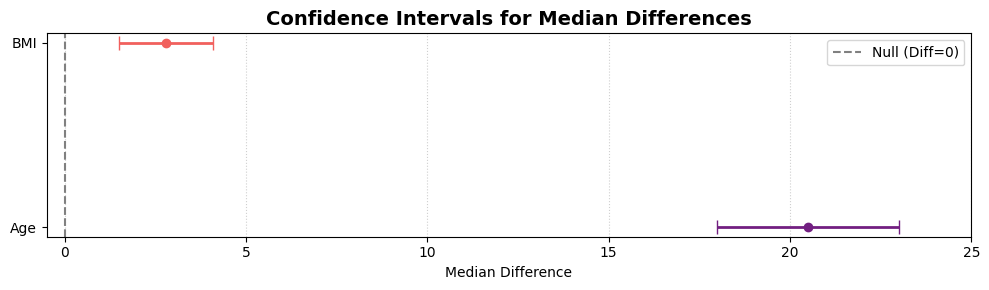

In [65]:
plot_median_differences(diff_data)

**Interpretation:**
- Age  show strong, significant associations with stroke risk.
- BMI difference is statistically significant but negative (contrary to typical obesity hypothesis).

Plotting odds ratios intervals:

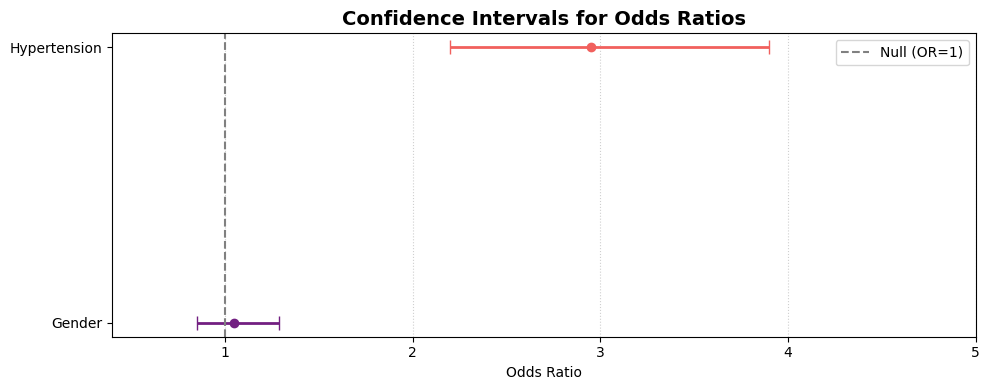

In [66]:
plot_odds_ratios(or_data)

**Interpretation:**
- Hypertension show strong, significant associations with stroke risk, but wide interval.
- Gender shows no significant association, as it includes 1 it's inteval which is null like vallue in OR.

## Feature Engineering


### New Features (groups)

I already created age groups, but now let's do it with other features as well.

#### Binning BMI

Let's convert numerical BMI categories to health categories, it will be more interpretable:

In [67]:
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese"]
df["bmi_category"] = pd.cut(df["bmi_capped"], bins=bmi_bins, labels=bmi_labels)

#### Leaving Smoking Categories Separate

I might consider unifying smoking categories under two larger groups (f. e.'smoked' vs 'never smoked'), but for that I need to explore their differences.

Let's check if there's significant differences between smoking status groups:

In [ ]:
def compare_smoking_groups(df, group1, group2):
    sub_df = df[df["smoking_status"].isin([group1, group2])]
    table = pd.crosstab(sub_df["smoking_status"], sub_df["stroke"])

    print(f"\nContingency Table: {group1} vs. {group2}")
    print(table)

    chi2, p, dof, expected = chi2_contingency(table)
    print("Expected Counts:")
    print(expected)

    if (expected < 5).any():
        print("Low expected counts detected, using Fisher's Exact Test")
        oddsratio, p_fisher = fisher_exact(table)
        print(f"Fisher's Exact Test p-value: {p_fisher:.4f}")
        print(f"Odds Ratio: {oddsratio:.2f}")
    else:
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p:.4f}")

In [69]:
pairs = [
    ("smokes", "formerly smoked"),
    ("smokes", "never smoked"),
    ("smokes", "Unknown"),
    ("formerly smoked", "never smoked"),
    ("formerly smoked", "Unknown"),
    ("never smoked", "Unknown"),
]

for pair in pairs:
    compare_smoking_groups(df, pair[0], pair[1])


Contingency Table: smokes vs. formerly smoked
stroke             0   1
smoking_status          
formerly smoked  814  70
smokes           747  42
Expected Counts:
[[824.82008368  59.17991632]
 [736.17991632  52.82008368]]
Chi-square statistic: 4.09
p-value: 0.0431

Contingency Table: smokes vs. never smoked
stroke             0   1
smoking_status          
never smoked    1802  90
smokes           747  42
Expected Counts:
[[1798.84669899   93.15330101]
 [ 750.15330101   38.84669899]]
Chi-square statistic: 0.27
p-value: 0.6033

Contingency Table: smokes vs. Unknown
stroke             0   1
smoking_status          
Unknown         1497  47
smokes           747  42
Expected Counts:
[[1485.09901414   58.90098586]
 [ 758.90098586   30.09901414]]
Chi-square statistic: 6.78
p-value: 0.0092

Contingency Table: formerly smoked vs. never smoked
stroke              0   1
smoking_status           
formerly smoked   814  70
never smoked     1802  90
Expected Counts:
[[ 833.04899135   50.95100865]


**Interpretation:** 

- Smokes vs. never smoked is the only group that is not significant.

- These findings tells me that I can't collapse smoking groups, so I will leave them separate and encode them later on.

#### Binning Average Glucose Levels

Binning glucose by different levels:

In [70]:
log_100 = np.log(100)
log_126 = np.log(126)
log_max = df["avg_glucose_level_log"].max()

bins_log = [0, log_100, log_126, log_max]
labels = ["Normal", "Prediabetes", "Diabetes"]

df["glucose_category_log"] = pd.cut(
    df["avg_glucose_level_log"], bins=bins_log, labels=labels
)

### Building and Testing Pipeline:

#### Pipeline Structure:


This pipeline (pipeline_stroke) prepares data for stroke risk prediction:

**Data cleaning and grouping:**

1. Standardizes Column Names: This happens as the very first operation within your CombinedFeatureTransformer.


2. Bins age into age_group categories: This is done within CombinedFeatureTransformer before BMI imputation, which relies on age_group.

3. Imputes missing bmi values using median per age_group: This is performed in CombinedFeatureTransformer after age_group creation.

4. Caps bmi outliers at the 99th percentile, creating bmi_capped: This happens in CombinedFeatureTransformer after BMI imputation.

5. Bins bmi_capped into bmi_category (Underweight, Normal, Overweight, Obese): This is done in CombinedFeatureTransformer after BMI capping.

6. Applies natural logarithm (np.log) to avg_glucose_level to create avg_glucose_level_log: This is handled in CombinedFeatureTransformer.

7. Bins avg_glucose_level_log into glucose_category_log (Normal, Prediabetes, Diabetes): This is performed in CombinedFeatureTransformer after the log transformation.

**Standardized preprocessing:**

8. Scales numerical features: hypertension and heart_disease are correctly scaled by StandardScaler within the perfect_data_preprocessor's num_scaler step. These features are already in their final numerical form.

9. Encodes categorical features: gender, ever_married, work_type, residence_type, smoking_status, age_group, bmi_category, and glucose_category_log are correctly encoded by OneHotEncoder within the perfect_data_preprocessor's cat_encoder step. This occurs after all custom transformations have created the final categorical features.

10. Drops any columns not explicitly processed: The remainder='drop' in perfect_data_preprocessor handles this effectively.

11. After perfect_data_preprocessor completes, your data is fully prepared in its numerical, encoded, and scaled format.

**Undersampling:**

12. If enabled, undersamples majority class to balance dataset. Only used during training. (Random UnderSampler)

**Classification:**


13. Classification: Finally, chosen estimator trains on the fully prepared and balanced data.

#### Evaluating Pipeline: No Undersampling



Training Pipeline (Undersample=False, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2916
           1       0.96      0.44      0.60       149

    accuracy                           0.97      3065
   macro avg       0.96      0.72      0.79      3065
weighted avg       0.97      0.97      0.97      3065


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       972
           1       0.24      0.10      0.14        50

    accuracy                           0.94      1022
   macro avg       0.60      0.54      0.55      1022
weighted avg       0.92      0.94      0.93      1022



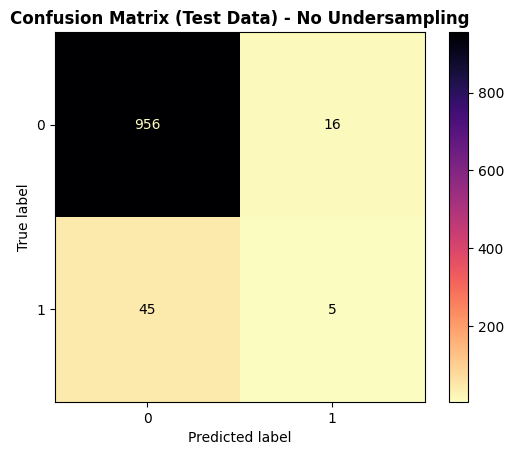

In [71]:
evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=False,
    use_weights=False,
    title_suffix="No Undersampling",
)

**Interpretation:** Pipeline runs correctly and learns, but even on training data it's biased toward the majority.
Lower recall (0.35) for class 1 = model misses many actual stroke cases.

#### Evaluating Pipeline: Undersampling 

I will try Undersampling to solve class imbalance:


Training Pipeline (Undersample=True, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      2916
           1       0.14      0.96      0.24       149

    accuracy                           0.71      3065
   macro avg       0.57      0.83      0.53      3065
weighted avg       0.96      0.71      0.79      3065


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       972
           1       0.09      0.64      0.16        50

    accuracy                           0.67      1022
   macro avg       0.53      0.66      0.48      1022
weighted avg       0.93      0.67      0.76      1022



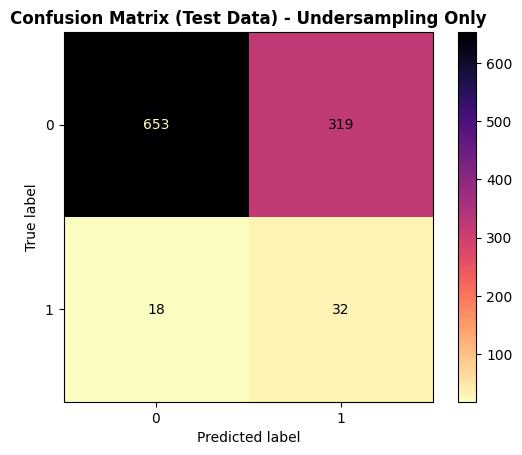

In [ ]:
evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=True,
    use_weights=False,
    title_suffix="Undersampling Only",
)

**Interpretation:** Undersampling version proved to be better as it treats 1 class with more balance,  it achieved way higher Recall (1 Class) than basic version and a bit lower precision.

### Feature Selection and Importances

I will look into feature importances and might modify with features to select for my pipeline. Training XGBoost:

In [ ]:
xgb_pipeline = pipeline_stroke(
    estimator=XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric="logloss"
    )
)

print("Training XGBoost pipeline...")
xgb_pipeline.fit(X_train, y_train)
print("XGBoost pipeline trained successfully.")

Training XGBoost pipeline...
XGBoost pipeline trained successfully.


Extracting feature importances:

In [ ]:
xgb_model = xgb_pipeline.named_steps["classifier"]

feature_importances = xgb_model.feature_importances_

feature_names_out = xgb_pipeline.named_steps[
    "final_preprocessing"
].get_feature_names_out()

importance_series = pd.Series(feature_importances, index=feature_names_out)
importance_series_sorted = importance_series.sort_values(ascending=False)

Plotting feature importances:

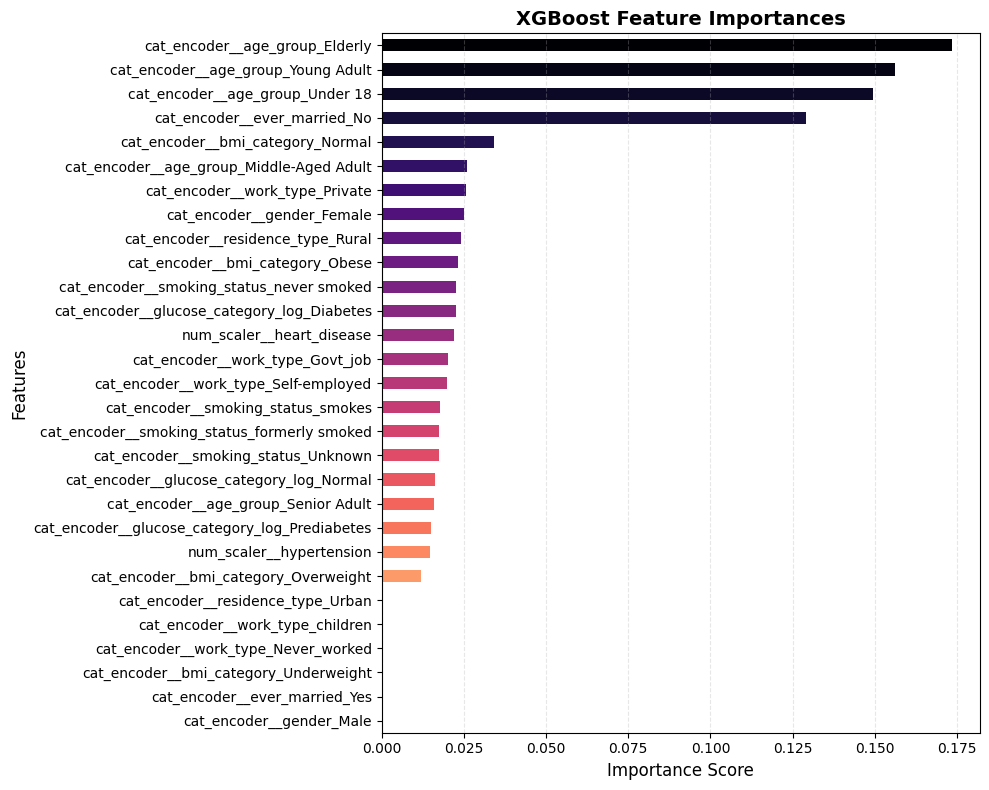

In [75]:
plt.figure(figsize=(10, 8))
importance_series_sorted.plot(
    kind="barh", color=plt.cm.magma(np.linspace(0, 1, len(importance_series_sorted)))
)

plt.title("XGBoost Feature Importances", fontsize=14, weight="bold")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()  # Largest at top
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

- Top Predictors: Age-related categories (especially Elderly), heart_disease, and ever_married_no are the most influential features for stroke prediction.

- Zero Importance: Features like residence_type_Urban, work_type_children, work_type_Never_worked, ever_married_Yes, and gender_Male have zero importance, indicating they were not used by the model for predictions.

-  All the original features (residence_type, work_type, ever_married, gender) that have a zero-importance one-hot encoded category also have other categories (or the numerical counterpart) with non-zero importance.

- I don't need to change numerical_final_features or categorical_final_features lists. My pipeline is already set up to handle this: the OneHotEncoder will create the columns, and the XGBoost model will simply ignore the ones with 0.000000 importance.

Since features single categories are separated, I will aggregate them to see group results:

Aggregated Feature Importances ---

age_group: 0.486853

smoking_status: 0.103746

bmi_category: 0.092406

glucose_category_log: 0.090023

work_type: 0.074069

---

ever_married: 0.039671

heart_disease: 0.036753

residence_type: 0.028560

gender: 0.024473

hypertension: 0.023444

I will choose only most most important full features and create a new pipeline that only includes age_group, smoking_status, bmi_category, glucose category, work_type as final features, to see if it could reach better results:


Training Pipeline (Undersample=True, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      2916
           1       0.13      0.88      0.23       149

    accuracy                           0.71      3065
   macro avg       0.56      0.79      0.53      3065
weighted avg       0.95      0.71      0.79      3065


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       972
           1       0.11      0.74      0.19        50

    accuracy                           0.68      1022
   macro avg       0.54      0.71      0.49      1022
weighted avg       0.94      0.68      0.77      1022



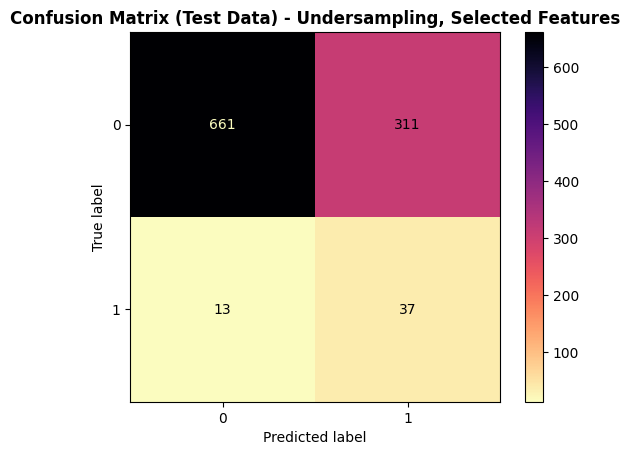

In [78]:
evaluate_pipeline_selected_features(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=True,
    use_weights=False,
    title_suffix="Undersampling, Selected Features",
)

**Interpretation:**

- Even better recall (Class 1) achieved than within all the features pipeline.

- Problem remains low precision.

- Since my priority is not missing strokes (high recall for class 1), I will stay with this selected features pipeline.

#### SMOTETomek (Oversampling + Undersampling) Pipeline

I will try one more pipeline with different sampling technique which combines oversampling and undersampling.


Training Pipeline (Undersample=True, Weights=True)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      2916
           1       0.16      0.98      0.28       149

    accuracy                           0.75      3065
   macro avg       0.58      0.86      0.57      3065
weighted avg       0.96      0.75      0.82      3065


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.11      0.64      0.19        50

    accuracy                           0.73      1022
   macro avg       0.54      0.69      0.51      1022
weighted avg       0.93      0.73      0.80      1022



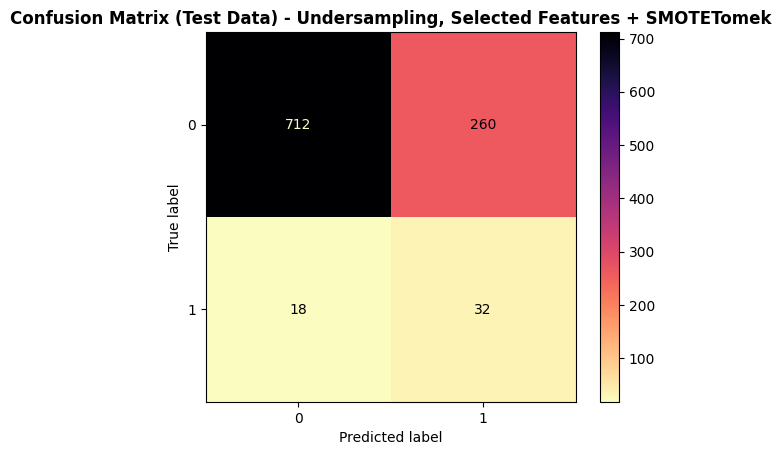

In [80]:
evaluate_pipeline_selected_features_smotetomek(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=True,
    use_weights=True,
    title_suffix="Undersampling, Selected Features + SMOTETomek",
)

**Interpretation:** SMOTETomek pipeline provided me with lower first class recall and similar precision, so I will stay with previous version of pipeline. 

## Model Developement: Training Models

### Base Models

First of all, I will compare base models training perfomances.

#### Dummy Classifier

**Notes:** Dummy Classifier makes predictions using simple rules without learning from the data. It’s used as a baseline to compare real models against.

In [81]:
# --- Baseline Model Setup on TRAINING DATA only ---

# 1. Instantiate the DummyClassifier
dummy_classifier = DummyClassifier(strategy="most_frequent", random_state=42)

# 2. Build the pipeline with the DummyClassifier
baseline_pipeline = pipeline_stroke_selected_features(dummy_classifier)

# 3. Train the baseline pipeline on training data
print("Training Dummy Classifier Pipeline on Training Data only...")
baseline_pipeline.fit(X_train, y_train)
print("Training complete.")

# 4. Make predictions on *training* data
y_pred_baseline_train = baseline_pipeline.predict(X_train)
y_prob_baseline_train = baseline_pipeline.predict_proba(X_train)[:, 1]

# 5. Evaluate the baseline model on *training* data
print("\n--- Dummy Classifier Performance on Training Data ---")
print(
    f"Precision (Class 1): {precision_score(y_train, y_pred_baseline_train, zero_division=0):.4f}"
)
print(
    f"Recall (Class 1): {recall_score(y_train, y_pred_baseline_train, zero_division=0):.4f}"
)
f1_macro_baseline_train = f1_score(
    y_train, y_pred_baseline_train, average="macro", zero_division=0
)
print(f"F1 Macro Score: {f1_macro_baseline_train:.4f}")

Training Dummy Classifier Pipeline on Training Data only...
Training complete.

--- Dummy Classifier Performance on Training Data ---
Precision (Class 1): 0.0000
Recall (Class 1): 0.0000
F1 Macro Score: 0.4875


**Interpretation:**

- Zero Precision, Recall (for the positive class): Since the model always predicts the majority class, it never correctly identifies any instances of the minority class (stroke).

- F1 Macro Score (0.4875): This score is close to 0.5, further confirming the model's inability to effectively classify both the majority and minority classes, as it treats them equally.

- These results establish a vital baseline: any meaningful model I build in the future must perform significantly better than these metrics, especially on Precision, Recall, F1-Score to be considered useful for predicting stroke. High accuracy alone is misleading in imbalanced datasets.

#### Logistic Regression

**Notes:** Logistic Regression draws a line (or boundary) to separate classes in the data. It predicts the probability of something belonging to one class or another.

In [82]:
from typing import Callable, Any, Optional, Union, Dict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score


def train_and_evaluate_logistic_regression(
    pipeline_function: Callable[..., Pipeline],
    X_train: Any,
    y_train: Any,
    undersample: bool,
    class_weight: Optional[Union[str, Dict]] = "balanced",
) -> None:
    """
    Train and evaluate a logistic regression model using a given pipeline function.
    Prints evaluation metrics and configuration details.

    Args:
        pipeline_function (Callable): Function that returns a scikit-learn Pipeline given an estimator and undersampling flag.
        X_train (pd.DataFrame or np.ndarray): Training feature data.
        y_train (pd.Series or np.ndarray): Training labels.
        undersample (bool): Whether to enable undersampling in the pipeline.
        class_weight (str or dict or None): Class weight parameter for LogisticRegression. E.g., 'balanced', None, or a custom dict.
    """
    logistic_regression_classifier = LogisticRegression(
        random_state=42, max_iter=1000, class_weight=class_weight
    )

    pipeline_model: Pipeline = pipeline_function(
        estimator=logistic_regression_classifier, undersample=undersample
    )

    print("\n============================")
    print(f"PIPELINE: {pipeline_function.__name__}")
    print(f"CLASS WEIGHT: {class_weight}")
    print(f"UNDERSAMPLING: {undersample}")
    print("============================\n")

    print("Training Logistic Regression Pipeline...")
    pipeline_model.fit(X_train, y_train)
    print("Training complete.")

    y_pred_train = pipeline_model.predict(X_train)
    y_prob_train = pipeline_model.predict_proba(X_train)[:, 1]

    precision = precision_score(y_train, y_pred_train, zero_division=0)
    recall = recall_score(y_train, y_pred_train, zero_division=0)
    f1_macro = f1_score(y_train, y_pred_train, average="macro", zero_division=0)

    print("\n--- TRAINING METRICS ---")
    print(f"Precision(Class 1): {precision:.4f}")
    print(f"Recall(Class 1): {recall:.4f}")
    print(f"F1 Macro Score: {f1_macro:.4f}")
    print("------------------------\n")

Training and evaluating pipeline:

In [83]:
train_and_evaluate_logistic_regression(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    class_weight="balanced",
)


PIPELINE: pipeline_stroke_selected_features
CLASS WEIGHT: balanced
UNDERSAMPLING: True

Training Logistic Regression Pipeline...
Training complete.

--- TRAINING METRICS ---
Precision(Class 1): 0.1210
Recall(Class 1): 0.8322
F1 Macro Score: 0.5122
------------------------



**Interpretation:** 

- Strong recall, very low precision.


- F1 Macro Score: score is only slightly better than a random baseline. 


### Advanced Models

#### Random Forest

**Notes:** Random Forest builds many decision trees independently on random parts of the data. It combines their results to make more stable and accurate predictions.

In [84]:
from typing import Callable, Any, Optional, Union, Dict
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score


def train_and_evaluate_random_forest(
    pipeline_function: Callable[..., Pipeline],
    X_train: Any,
    y_train: Any,
    undersample: bool,
    class_weight: Optional[Union[str, Dict]] = "balanced",
    n_estimators: int = 100,
) -> None:
    """
    Train and evaluate a Random Forest model using a given pipeline function on training data.
    Prints evaluation metrics and configuration details.

    Args:
        pipeline_function (Callable): Function returning a scikit-learn Pipeline given an estimator and undersampling flag.
        X_train (pd.DataFrame or np.ndarray): Feature data to train and evaluate on.
        y_train (pd.Series or np.ndarray): Labels to train and evaluate on.
        undersample (bool): Whether to enable undersampling in the pipeline.
        class_weight (str, dict, or None): Class weighting scheme for RandomForestClassifier.
        n_estimators (int): Number of trees in the forest.
    """
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators, class_weight=class_weight, random_state=42
    )

    pipeline_model: Pipeline = pipeline_function(
        estimator=rf_classifier, undersample=undersample
    )

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"CLASS WEIGHT: {class_weight}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"N_ESTIMATORS: {n_estimators}")
    print("============================\n")

    print("Training Random Forest Pipeline...")
    pipeline_model.fit(X_train, y_train)
    print("Training complete.")

    y_pred_train = pipeline_model.predict(X_train)

    precision = precision_score(y_train, y_pred_train, zero_division=0)
    recall = recall_score(y_train, y_pred_train, zero_division=0)
    f1_macro = f1_score(y_train, y_pred_train, average="macro", zero_division=0)

    print("\n--- RANDOM FOREST TRAINING METRICS ---")
    print(f"Precision (Class 1): {precision:.4f}")
    print(f"Recall (Class 1): {recall:.4f}")
    print(f"F1 Macro Score: {f1_macro:.4f}")
    print("---------------------------------------\n")

RF training version 1 :

In [85]:
train_and_evaluate_random_forest(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    class_weight="balanced",
    n_estimators=100,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
CLASS WEIGHT: balanced
UNDERSAMPLING: True
N_ESTIMATORS: 100

Training Random Forest Pipeline...
Training complete.

--- RANDOM FOREST TRAINING METRICS ---
Precision (Class 1): 0.1269
Recall (Class 1): 0.8859
F1 Macro Score: 0.5174
---------------------------------------



**Interpretation:**

- Precision remains very low, high recall.

- Performance very similar to LR.

#### XGBoost

**Notes:** XGBoost creates many decision trees step by step, with each new tree correcting the last one's mistakes. It focuses on speed and accuracy, making strong predictions even on complex data.

In [86]:
from typing import Callable, Any, Optional
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score


def train_and_evaluate_xgboost(
    pipeline_function: Callable[..., Pipeline],
    X_train: Any,
    y_train: Any,
    undersample: bool,
    n_estimators: int = 100,
    weight: Optional[float] = None,
) -> None:
    """
    Train and evaluate an XGBoost model using a given pipeline function on training data.
    Prints evaluation metrics and configuration details.

    If 'weight' is not provided, scale_pos_weight will be automatically calculated from y_train.

    Args:
        pipeline_function (Callable): Function returning a scikit-learn Pipeline given an estimator and undersampling flag.
        X_train (pd.DataFrame or np.ndarray): Feature data to train and evaluate on.
        y_train (pd.Series or np.ndarray): Labels to train and evaluate on.
        undersample (bool): Whether to enable undersampling in the pipeline.
        n_estimators (int): Number of boosting rounds.
        weight (float, optional): scale_pos_weight for XGBoost; if None, computed automatically.
    """
    if weight is None:
        neg_count = (y_train == 0).sum()
        pos_count = (y_train == 1).sum()
        weight = neg_count / pos_count

    xgb_classifier = XGBClassifier(
        objective="binary:logistic",
        n_estimators=n_estimators,
        scale_pos_weight=weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )

    pipeline_model: Pipeline = pipeline_function(
        estimator=xgb_classifier, undersample=undersample
    )

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"SCALE_POS_WEIGHT: {weight:.4f}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"N_ESTIMATORS: {n_estimators}")
    print("============================\n")

    print("Training XGBoost Pipeline...")
    pipeline_model.fit(X_train, y_train)
    print("Training complete.")

    y_pred_train = pipeline_model.predict(X_train)

    precision = precision_score(y_train, y_pred_train, zero_division=0)
    recall = recall_score(y_train, y_pred_train, zero_division=0)
    f1_macro = f1_score(y_train, y_pred_train, average="macro", zero_division=0)

    print("\n--- XGBOOST TRAINING METRICS ---")
    print(f"Precision (Class 1): {precision:.4f}")
    print(f"Recall (Class 1): {recall:.4f}")
    print(f"F1 Macro Score: {f1_macro:.4f}")
    print("---------------------------------\n")

XGBoost training and evaluating:

In [87]:
train_and_evaluate_xgboost(
    pipeline_function=pipeline_stroke_selected_features,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    n_estimators=300,
    weight=1,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
N_ESTIMATORS: 300

Training XGBoost Pipeline...
Training complete.

--- XGBOOST TRAINING METRICS ---
Precision (Class 1): 0.1288
Recall (Class 1): 0.8725
F1 Macro Score: 0.5220
---------------------------------



**Interpretation:**

- High recall, very low precision.

- Overall, XGBoost offers higher f1 macro score better balance than base models.


#### LightGBM

**Notes:** LightGBM builds lots of decision trees quickly, each one fixing the errors of the previous ones. It’s designed to be very fast and accurate, handling large datasets and both numerical and categorical data well.

In [88]:
from typing import Callable, Any, Optional
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score


def train_and_evaluate_lightgbm(
    pipeline_function: Callable[..., Pipeline],
    X_train: Any,
    y_train: Any,
    undersample: bool,
    n_estimators: int = 100,
    weight: Optional[float] = None,
) -> None:
    """
    Train and evaluate a LightGBM model using a given pipeline function on training data.
    Prints evaluation metrics and configuration details.

    If 'weight' is not provided, scale_pos_weight will be automatically calculated from y_train.

    Args:
        pipeline_function (Callable): Function returning a scikit-learn Pipeline given an estimator and undersampling flag.
        X_train (pd.DataFrame or np.ndarray): Feature data to train and evaluate on.
        y_train (pd.Series or np.ndarray): Labels to train and evaluate on.
        undersample (bool): Whether to enable undersampling in the pipeline.
        n_estimators (int): Number of boosting rounds.
        weight (float, optional): scale_pos_weight for LightGBM; if None, computed automatically.
    """
    if weight is None:
        neg_count = (y_train == 0).sum()
        pos_count = (y_train == 1).sum()
        weight = neg_count / pos_count

    lgbm_classifier = LGBMClassifier(
        objective="binary",
        n_estimators=n_estimators,
        scale_pos_weight=weight,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )

    pipeline_model: Pipeline = pipeline_function(
        estimator=lgbm_classifier, undersample=undersample
    )

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"SCALE_POS_WEIGHT: {weight:.4f}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"N_ESTIMATORS: {n_estimators}")
    print("============================\n")

    print("Training LightGBM Pipeline...")
    pipeline_model.fit(X_train, y_train)
    print("Training complete.")

    y_pred_train = pipeline_model.predict(X_train)

    precision = precision_score(y_train, y_pred_train, zero_division=0)
    recall = recall_score(y_train, y_pred_train, zero_division=0)
    f1_macro = f1_score(y_train, y_pred_train, average="macro", zero_division=0)

    print("\n--- LIGHTGBM TRAINING METRICS ---")
    print(f"Precision (Class 1): {precision:.4f}")
    print(f"Recall (Class 1): {recall:.4f}")
    print(f"F1 Macro Score: {f1_macro:.4f}")
    print("---------------------------------\n")

Training and evaluating LightGBM:

In [89]:
train_and_evaluate_lightgbm(
    pipeline_function=pipeline_stroke,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    n_estimators=1500,
    weight=0.3,
)


PIPELINE FUNCTION: pipeline_stroke
SCALE_POS_WEIGHT: 0.3000
UNDERSAMPLING: True
N_ESTIMATORS: 1500

Training LightGBM Pipeline...
Training complete.

--- LIGHTGBM TRAINING METRICS ---
Precision (Class 1): 0.1457
Recall (Class 1): 0.9262
F1 Macro Score: 0.5445
---------------------------------



**Interpretation:**

- Very high recall, low precision, quite similar as XGBoost.

- Overall, XGBoost offered higher f1 macro score, but LightGBM had way higher Recall (Class 1).

#### Cat Boost

**Notes:** CatBoost builds many simple decision trees, each one learning from the mistakes of the last. By combining them all, it makes very accurate predictions even with tricky, categorical data.

In [90]:
from typing import Callable, Any, Optional
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score


def train_and_evaluate_catboost(
    pipeline_function: Callable[..., Pipeline],
    X_train: Any,
    y_train: Any,
    undersample: bool,
    iterations: int = 100,
    weight: Optional[float] = None,
) -> None:
    """
    Train and evaluate a CatBoost model using a given pipeline function on training data.
    Prints evaluation metrics and configuration details.

    If 'weight' is not provided, scale_pos_weight will be automatically calculated from y_train.

    Args:
        pipeline_function (Callable): Function returning a scikit-learn Pipeline given an estimator and undersampling flag.
        X_train (pd.DataFrame or np.ndarray): Feature data to train and evaluate on.
        y_train (pd.Series or np.ndarray): Labels to train and evaluate on.
        undersample (bool): Whether to enable undersampling in the pipeline.
        iterations (int): Number of boosting rounds.
        weight (float, optional): scale_pos_weight for CatBoost; if None, computed automatically.
    """
    if weight is None:
        neg_count = (y_train == 0).sum()
        pos_count = (y_train == 1).sum()
        weight = neg_count / pos_count

    catboost_classifier = CatBoostClassifier(
        objective="Logloss",
        iterations=iterations,
        scale_pos_weight=weight,
        random_seed=42,
        verbose=0,
    )

    pipeline_model: Pipeline = pipeline_function(
        estimator=catboost_classifier, undersample=undersample
    )

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"SCALE_POS_WEIGHT: {weight:.4f}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"ITERATIONS: {iterations}")
    print("============================\n")

    print("Training CatBoost Pipeline...")
    pipeline_model.fit(X_train, y_train)
    print("Training complete.")

    y_pred_train = pipeline_model.predict(X_train)

    precision = precision_score(y_train, y_pred_train, zero_division=0)
    recall = recall_score(y_train, y_pred_train, zero_division=0)
    f1_macro = f1_score(y_train, y_pred_train, average="macro", zero_division=0)

    print("\n--- CATBOOST TRAINING METRICS ---")
    print(f"Precision (Class 1): {precision:.4f}")
    print(f"Recall (Class 1): {recall:.4f}")
    print(f"F1 Macro Score: {f1_macro:.4f}")
    print("---------------------------------\n")

Training and evaluating CatBoost:

In [91]:
train_and_evaluate_catboost(
    pipeline_function=pipeline_stroke,
    X_train=X_train,
    y_train=y_train,
    undersample=True,
    iterations=1000,
    weight=0.25,
)


PIPELINE FUNCTION: pipeline_stroke
SCALE_POS_WEIGHT: 0.2500
UNDERSAMPLING: True
ITERATIONS: 1000

Training CatBoost Pipeline...
Training complete.

--- CATBOOST TRAINING METRICS ---
Precision (Class 1): 0.2124
Recall (Class 1): 0.7584
F1 Macro Score: 0.6242
---------------------------------



**Interpretation:** 

- Highest precision of all models.

- Remains with quite high recall.

- Overall, Catboost had best f1 macro score.

#### Comparing all models best training versions (F1 Macro)

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, List


def plot_model_f1_macro_scores(
    models: List[str],
    scores: List[float],
    title: Optional[str] = "F1 Macro Scores of Trained Models",
    ylabel: Optional[str] = "F1 Macro Score",
    ylim: Optional[Tuple[float, float]] = (0.4, 0.8),
) -> None:
    """
    Plot a sorted bar chart of F1 Macro Scores for different models.

    Args:
        models (List[str]): List of model names.
        scores (List[float]): Corresponding list of F1 Macro scores.
        title (Optional[str]): Title of the plot.
        ylabel (Optional[str]): Label for the y-axis.
        ylim (Optional[Tuple[float, float]]): Limits for the y-axis.
    """
    df = pd.DataFrame({"Model": models, "F1 Macro Score": scores})

    df_sorted = df.sort_values(by="F1 Macro Score", ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x="Model",
        y="F1 Macro Score",
        data=df_sorted,
        palette="magma",
        hue="Model",
        legend=False,
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if ylim:
        plt.ylim(*ylim)
    plt.xticks(rotation=45, ha="right")

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.4f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
            color="black",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

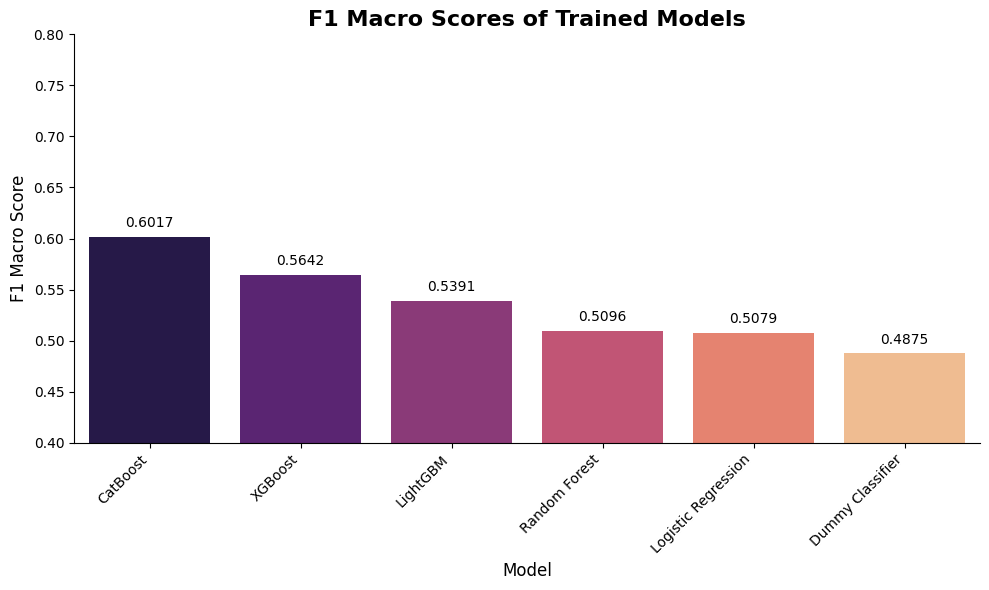

In [93]:
plot_model_f1_macro_scores(
    models=[
        "Dummy Classifier",
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "CatBoost",
    ],
    scores=[
        0.4875,
        0.5079,
        0.5096,
        0.5642,
        0.5391,
        0.6017,
    ],
)

**Interpretation:***

- Overall, all models show improvement comparing with Dummy Classifier.

- CatBoost achieved highest F1 Macro score.

In [94]:
def plot_model_recall_precision(
    models: List[str],
    recalls: List[float],
    precisions: List[float],
    title: Optional[str] = "Recall and Precision (Class 1) of Trained Models",
    ylabel: Optional[str] = "Score",
    ylim: Optional[Tuple[float, float]] = (0.0, 1.0),
) -> None:
    data = {
        "Model": models * 2,
        "Metric": ["Recall"] * len(models) + ["Precision"] * len(models),
        "Score": recalls + precisions,
    }
    df = pd.DataFrame(data)
    df = df[df["Score"] > 0.0]

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Model", y="Score", hue="Metric", data=df, palette="magma")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if ylim:
        plt.ylim(*ylim)
    plt.xticks(rotation=45, ha="right")

    for p in ax.patches:
        height = p.get_height()
        if height > 0.01:
            ax.annotate(
                f"{height:.4f}",
                (p.get_x() + p.get_width() / 2.0, height),
                ha="center",
                va="center",
                xytext=(0, 8),
                textcoords="offset points",
                fontsize=9,
                color="black",
            )

    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

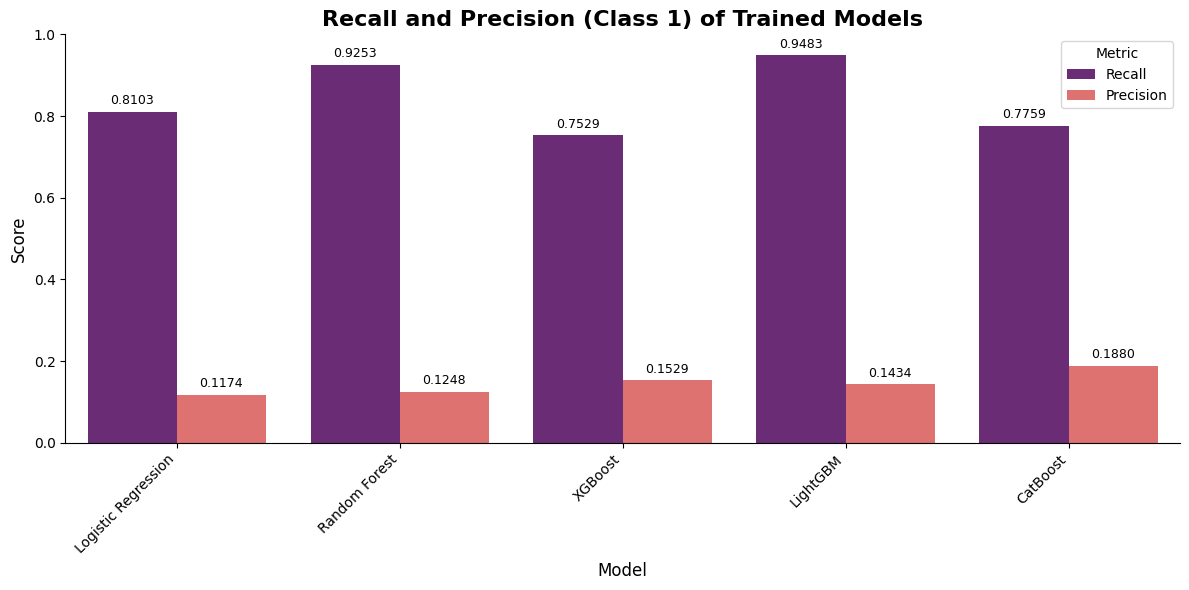

In [95]:
plot_model_recall_precision(
    models=[
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "CatBoost",
    ],
    recalls=[
        0.8103,
        0.9253,
        0.7529,
        0.9483,
        0.7759,
    ],
    precisions=[
        0.1174,
        0.1248,
        0.1529,
        0.1434,
        0.1880,
    ],
)

**Interpretation:** 
- High recall, low precision across models.
- CatBoost best balance (highest precision).
- LightGBM, RF push recall very high, precision drops.
- Classic imbalanced trade-off.

## Cross-Validation

I will use cross-validation tests to see how well models generalizes to unseen data.



In [96]:
from sklearn.linear_model import LogisticRegression
from typing import Callable, Any, Optional
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


def cross_validate_logistic_regression(
    pipeline_function: Callable[..., Any],
    X: Any,
    y: Any,
    class_weight: Optional[str] = "balanced",
    undersample: bool = False,
    n_splits: int = 5,
    random_state: int = 42,
) -> None:
    """
    Perform stratified K-fold cross-validation for a Logistic Regression model
    and print average F1 Macro, Recall (Class 1), and Precision (Class 1).

    Args:
        pipeline_function (Callable): Function returning a pipeline given an estimator.
        X (pd.DataFrame or np.ndarray): Features.
        y (pd.Series or np.ndarray): Target labels.
        class_weight (str or None): Class weighting scheme.
        undersample (bool): Whether to include undersampling in the pipeline.
        n_splits (int): Number of cross-validation folds.
        random_state (int): Random seed for reproducibility.
    """
    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"CLASS WEIGHT: {class_weight}")
    print(f"UNDERSAMPLING: {undersample}")
    print("============================\n")

    lr_classifier = LogisticRegression(
        class_weight=class_weight, random_state=random_state, max_iter=1000
    )

    pipeline_model = pipeline_function(
        estimator=lr_classifier, undersample=undersample, random_state=random_state
    )

    cv_strategy = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    scoring = {
        "precision_class_1": make_scorer(precision_score, zero_division=0),
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    }

    print(
        f"Performing {n_splits}-fold Stratified Cross-Validation for Logistic Regression..."
    )
    cv_results = cross_validate(
        pipeline_model,
        X,
        y,
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
    )
    print("Cross-validation complete.")

    print("\n--- Logistic Regression Cross-Validation Results ---")
    for metric in ["f1_macro", "recall_class_1", "precision_class_1"]:
        scores = cv_results[f"test_{metric}"]
        print(
            f"{metric.replace('_', ' ').title()}: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Cross-validating LR:

In [97]:
cross_validate_logistic_regression(
    pipeline_function=pipeline_stroke_selected_features,
    X=X,
    y=y,
    class_weight="balanced",
    undersample=True,
    n_splits=5,
    random_state=24,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
CLASS WEIGHT: balanced
UNDERSAMPLING: True

Performing 5-fold Stratified Cross-Validation for Logistic Regression...
Cross-validation complete.

--- Logistic Regression Cross-Validation Results ---
F1 Macro: Mean = 0.5215, Std = 0.0200
Recall Class 1: Mean = 0.7993, Std = 0.0351
Precision Class 1: Mean = 0.1255, Std = 0.0128


#### Random Forest CV

In [98]:
from typing import Callable, Any, Optional
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


def cross_validate_random_forest(
    pipeline_function: Callable[..., Any],
    X: Any,
    y: Any,
    n_estimators: int = 100,
    class_weight: Optional[str] = "balanced",
    undersample: bool = False,
    n_splits: int = 5,
    random_state: int = 42,
) -> None:
    """
    Perform stratified K-fold cross-validation for a Random Forest model
    and print average F1 Macro, Recall (Class 1), and Precision (Class 1).

    Args:
        pipeline_function (Callable): Function returning a pipeline given an estimator.
        X (pd.DataFrame or np.ndarray): Features.
        y (pd.Series or np.ndarray): Target labels.
        n_estimators (int): Number of trees in the forest.
        class_weight (str or None): Class weighting scheme.
        undersample (bool): Whether to include undersampling in the pipeline.
        n_splits (int): Number of cross-validation folds.
        random_state (int): Random seed for reproducibility.
    """
    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"CLASS WEIGHT: {class_weight}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"N_ESTIMATORS: {n_estimators}")
    print("============================\n")

    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight=class_weight,
        random_state=random_state,
    )

    pipeline_model = pipeline_function(
        estimator=rf_classifier, undersample=undersample, random_state=random_state
    )

    cv_strategy = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    scoring = {
        "precision_class_1": make_scorer(precision_score, zero_division=0),
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    }

    print(
        f"Performing {n_splits}-fold Stratified Cross-Validation for Random Forest..."
    )
    cv_results = cross_validate(
        pipeline_model,
        X,
        y,
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
    )
    print("Cross-validation complete.")

    print("\n--- Random Forest Cross-Validation Results ---")
    for metric in ["f1_macro", "recall_class_1", "precision_class_1"]:
        scores = cv_results[f"test_{metric}"]
        print(
            f"{metric.replace('_', ' ').title()}: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Cross-validating RF:

In [99]:
cross_validate_random_forest(
    pipeline_function=pipeline_stroke_selected_features,
    X=X,
    y=y,
    n_estimators=100,
    class_weight=None,
    undersample=True,
    n_splits=5,
    random_state=24,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
CLASS WEIGHT: None
UNDERSAMPLING: True
N_ESTIMATORS: 100

Performing 5-fold Stratified Cross-Validation for Random Forest...
Cross-validation complete.

--- Random Forest Cross-Validation Results ---
F1 Macro: Mean = 0.5037, Std = 0.0147
Recall Class 1: Mean = 0.7553, Std = 0.0655
Precision Class 1: Mean = 0.1122, Std = 0.0097


#### XGBoost Cross-Validation

In [100]:
from typing import Callable, Any, Optional
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from xgboost import XGBClassifier


def cross_validate_xgboost(
    pipeline_function: Callable[..., Any],
    X: Any,
    y: Any,
    n_estimators: int = 200,
    weight: Optional[float] = None,
    n_splits: int = 5,
    random_state: int = 42,
    undersample: bool = False,
) -> None:
    """
    Perform stratified K-fold cross-validation for an XGBoost model
    and print average F1 Macro, Recall (Class 1), and Precision (Class 1).

    If 'weight' is not provided, scale_pos_weight will be automatically calculated from y.

    Args:
        pipeline_function (Callable): Function returning a pipeline given an estimator.
        X (pd.DataFrame or np.ndarray): Features.
        y (pd.Series or np.ndarray): Target labels.
        n_estimators (int): Number of boosting rounds.
        weight (float, optional): scale_pos_weight for XGBoost; if None, computed automatically.
        n_splits (int): Number of cross-validation folds.
        random_state (int): Random seed for reproducibility.
        undersample (bool): Whether to enable undersampling in the pipeline.
    """
    if weight is None:
        neg_count = (y == 0).sum()
        pos_count = (y == 1).sum()
        weight = neg_count / pos_count

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"SCALE_POS_WEIGHT: {weight:.4f}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"N_ESTIMATORS: {n_estimators}")
    print("============================\n")

    xgb_classifier = XGBClassifier(
        objective="binary:logistic",
        n_estimators=n_estimators,
        scale_pos_weight=weight,
        random_state=random_state,
        verbosity=0,
        eval_metric="logloss",
        disable_default_eval_metric=True,
    )

    pipeline_model = pipeline_function(
        estimator=xgb_classifier, undersample=undersample
    )

    cv_strategy = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    scoring = {
        "precision_class_1": make_scorer(precision_score, zero_division=0),
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    }

    print(f"Performing {n_splits}-fold Stratified Cross-Validation for XGBoost...")
    cv_results = cross_validate(
        pipeline_model,
        X,
        y,
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
    )
    print("Cross-validation complete.")

    print("\n--- XGBoost Cross-Validation Results ---")
    for metric in ["f1_macro", "recall_class_1", "precision_class_1"]:
        scores = cv_results[f"test_{metric}"]
        print(
            f"{metric.replace('_', ' ').title()}: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Cross-validating XGBoost:

In [101]:
cross_validate_xgboost(
    pipeline_function=pipeline_stroke_selected_features_smote_tomek,
    X=X,
    y=y,
    n_estimators=1000,
    weight=1,
    undersample=True,
    n_splits=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features_smote_tomek
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
N_ESTIMATORS: 1000

Performing 5-fold Stratified Cross-Validation for XGBoost...
Cross-validation complete.

--- XGBoost Cross-Validation Results ---
F1 Macro: Mean = 0.5695, Std = 0.0246
Recall Class 1: Mean = 0.3578, Std = 0.0852
Precision Class 1: Mean = 0.1492, Std = 0.0312


#### LightGBM CV

In [102]:
import warnings
import sys
import os
from contextlib import redirect_stderr
from typing import Callable, Any, Optional
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier


def cross_validate_lightgbm(
    pipeline_function: Callable[..., Any],
    X: Any,
    y: Any,
    n_estimators: int = 100,
    weight: Optional[float] = None,
    n_splits: int = 5,
    random_state: int = 42,
    undersample: bool = False,
) -> None:
    """
    Perform stratified K-fold cross-validation for a LightGBM model
    and print average F1 Macro, Recall (Class 1), and Precision (Class 1).
    Suppresses LightGBM logs and scikit-learn UserWarnings for cleaner output.

    If 'weight' is not provided, scale_pos_weight will be automatically calculated from y.

    Args:
        pipeline_function (Callable): Function returning a pipeline given an estimator.
        X (pd.DataFrame or np.ndarray): Features.
        y (pd.Series or np.ndarray): Target labels.
        n_estimators (int): Number of boosting rounds.
        weight (float, optional): scale_pos_weight for LightGBM; if None, computed automatically.
        n_splits (int): Number of cross-validation folds.
        random_state (int): Random seed for reproducibility.
        undersample (bool): Whether to enable undersampling in the pipeline.
    """
    if weight is None:
        neg_count = (y == 0).sum()
        pos_count = (y == 1).sum()
        weight = neg_count / pos_count

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"SCALE_POS_WEIGHT: {weight:.4f}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"N_ESTIMATORS: {n_estimators}")
    print("============================\n")

    lgbm_classifier = LGBMClassifier(
        objective="binary",
        n_estimators=n_estimators,
        scale_pos_weight=weight,
        random_state=random_state,
        n_jobs=-1,
        verbose=-1,
    )

    pipeline_model = pipeline_function(
        estimator=lgbm_classifier, undersample=undersample
    )

    cv_strategy = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    scoring = {
        "precision_class_1": make_scorer(precision_score, zero_division=0),
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    }

    print(f"Performing {n_splits}-fold Stratified Cross-Validation for LightGBM...")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as devnull, redirect_stderr(devnull):
            cv_results = cross_validate(
                pipeline_model,
                X,
                y,
                cv=cv_strategy,
                scoring=scoring,
                return_train_score=False,
                n_jobs=-1,
            )

    print("Cross-validation complete.")

    print("\n--- LightGBM Cross-Validation Results ---")
    for metric in ["f1_macro", "recall_class_1", "precision_class_1"]:
        scores = cv_results[f"test_{metric}"]
        print(
            f"{metric.replace('_', ' ').title()}: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Cross-validating LightGBM:

In [103]:
cross_validate_lightgbm(
    pipeline_function=pipeline_stroke_selected_features,
    X=X,
    y=y,
    n_estimators=1000,
    weight=1,
    undersample=True,
    n_splits=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
N_ESTIMATORS: 1000

Performing 5-fold Stratified Cross-Validation for LightGBM...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Cross-validation complete.

--- LightGBM Cross-Validation Results ---
F1 Macro: Mean = 0.4854, Std = 0.0118
Recall Class 1: Mean = 0.6913, Std = 0.0834
Precision Class 1: Mean = 0.0983, Std = 0.0099


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### CatBoost CV

In [104]:
import warnings
import sys
import os
from contextlib import redirect_stderr
from typing import Callable, Any, Optional
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier


def cross_validate_catboost(
    pipeline_function: Callable[..., Any],
    X: Any,
    y: Any,
    iterations: int = 100,
    weight: Optional[float] = None,
    n_splits: int = 5,
    random_state: int = 42,
    undersample: bool = False,
) -> None:
    """
    Perform stratified K-fold cross-validation for a CatBoost model
    and print average F1 Macro, Recall (Class 1), and Precision (Class 1).
    Suppresses CatBoost logs and scikit-learn UserWarnings for cleaner output.

    If 'weight' is not provided, scale_pos_weight will be automatically calculated from y.

    Args:
        pipeline_function (Callable): Function returning a pipeline given an estimator.
        X (pd.DataFrame or np.ndarray): Features.
        y (pd.Series or np.ndarray): Target labels.
        iterations (int): Number of boosting rounds.
        weight (float, optional): scale_pos_weight for CatBoost; if None, computed automatically.
        n_splits (int): Number of cross-validation folds.
        random_state (int): Random seed for reproducibility.
        undersample (bool): Whether to enable undersampling in the pipeline.
    """
    if weight is None:
        neg_count = (y == 0).sum()
        pos_count = (y == 1).sum()
        weight = neg_count / pos_count

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"SCALE_POS_WEIGHT: {weight:.4f}")
    print(f"UNDERSAMPLING: {undersample}")
    print(f"ITERATIONS: {iterations}")
    print("============================\n")

    catboost_classifier = CatBoostClassifier(
        iterations=iterations,
        loss_function="Logloss",
        scale_pos_weight=weight,
        random_seed=random_state,
        verbose=0,
    )

    pipeline_model = pipeline_function(
        estimator=catboost_classifier, undersample=undersample
    )

    cv_strategy = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    scoring = {
        "precision_class_1": make_scorer(precision_score, zero_division=0),
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    }

    print(f"Performing {n_splits}-fold Stratified Cross-Validation for CatBoost...")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as devnull, redirect_stderr(devnull):
            cv_results = cross_validate(
                pipeline_model,
                X,
                y,
                cv=cv_strategy,
                scoring=scoring,
                return_train_score=False,
                n_jobs=-1,
            )

    print("Cross-validation complete.")

    print("\n--- CatBoost Cross-Validation Results ---")
    for metric in ["f1_macro", "recall_class_1", "precision_class_1"]:
        scores = cv_results[f"test_{metric}"]
        print(
            f"{metric.replace('_', ' ').title()}: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Cross-validating CatBoost:

In [105]:
cross_validate_catboost(
    pipeline_function=pipeline_stroke_selected_features_smote_tomek,
    X=X,
    y=y,
    iterations=1000,
    weight=1,
    undersample=True,
    n_splits=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features_smote_tomek
SCALE_POS_WEIGHT: 1.0000
UNDERSAMPLING: True
ITERATIONS: 1000

Performing 5-fold Stratified Cross-Validation for CatBoost...
Cross-validation complete.

--- CatBoost Cross-Validation Results ---
F1 Macro: Mean = 0.5687, Std = 0.0221
Recall Class 1: Mean = 0.3740, Std = 0.0870
Precision Class 1: Mean = 0.1480, Std = 0.0275


#### Comparing All Models CV Results

In [106]:
def plot_model_cv_metrics_comparison(
    models: List[str],
    f1_macro_scores: List[float],
    recalls: List[float],
    precisions: List[float],
    title: Optional[str] = "Comparison of CV Metrics by Model",
    xlabel: Optional[str] = "Score",
    xlim: Optional[Tuple[float, float]] = (0.0, 1.0),
) -> None:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    data = {
        "Model": models * 3,
        "Metric": ["F1 Macro"] * len(models)
        + ["Recall (Class 1)"] * len(models)
        + ["Precision (Class 1)"] * len(models),
        "Score": f1_macro_scores + recalls + precisions,
    }
    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(y="Model", x="Score", hue="Metric", data=df, palette="magma")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Model", fontsize=12)
    if xlim:
        plt.xlim(*xlim)
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    for p in ax.patches:
        width = p.get_width()
        if width > 0.01:
            ax.annotate(
                f"{width:.4f}",
                (width + 0.01, p.get_y() + p.get_height() / 2),
                ha="left",
                va="center",
                fontsize=9,
                color="black",
            )

    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

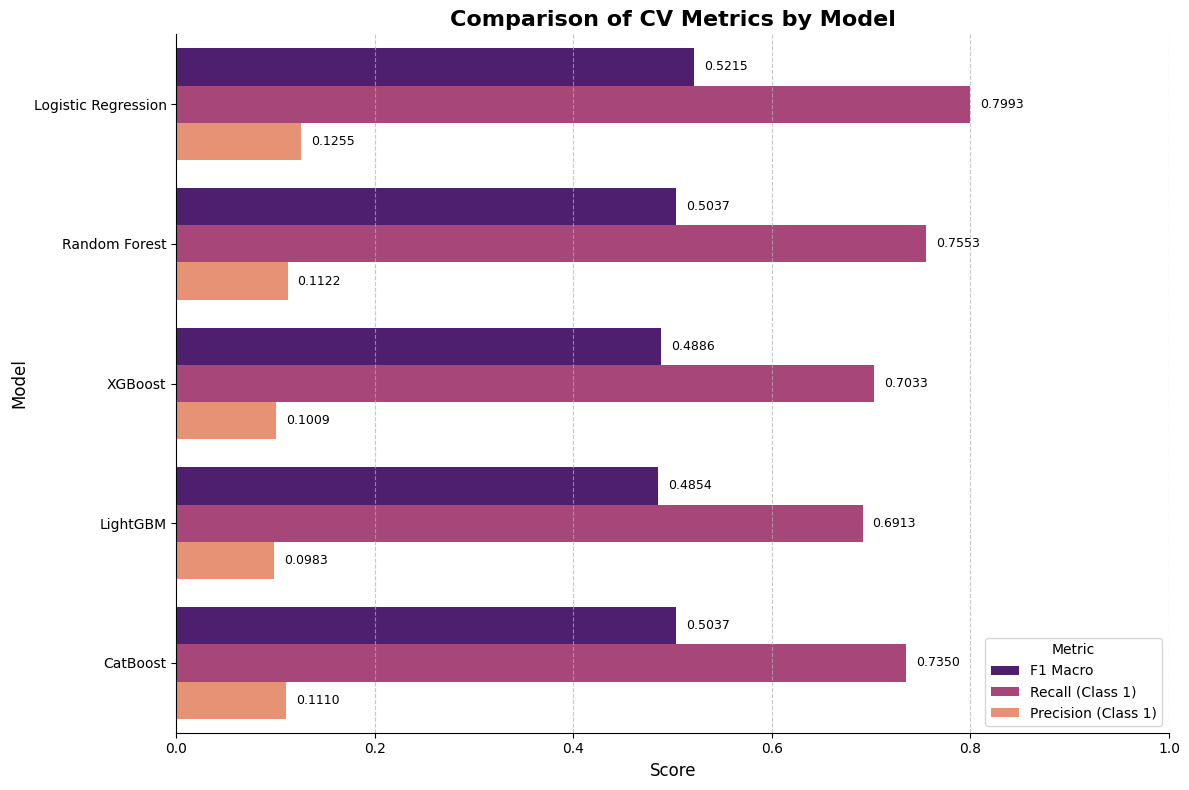

In [107]:
plot_model_cv_metrics_comparison(
    models=[
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "CatBoost",
    ],
    f1_macro_scores=[
        0.5215,
        0.5037,
        0.4886,
        0.4854,
        0.5037,
    ],
    recalls=[
        0.7993,
        0.7553,
        0.7033,
        0.6913,
        0.7350,
    ],
    precisions=[
        0.1255,
        0.1122,
        0.1009,
        0.0983,
        0.1110,
    ],
    xlim=(0.0, 1.0),
)

**Interpretation:** 

- Models are over aggressive, meaning high recall and low precision remains biggest issue.

- Model differences  got "washed out" by the data transformation, most likely from Undersampling option.

- I will proceed to a Hyperparameter Tuning with LR, RF and CatBoost since they performed a bit better.

## Hyperparameter Tuning

### Hyperparameter Tuning: LR

I will use  RandomizedSearchCV, because it’s faster and more efficient than GridSearchCV.

**LR Tuning Notes:**
- C: Inverse of regularization strength. Lower = stronger regularization (simpler model). Typical range: 0.001–100.
- penalty: Type of regularization. 'l2' is ridge-like, helps control weights.
- solver: Algorithm to fit the model. 'lbfgs' and 'liblinear' handle small datasets well.
- class_weight: Adjusts balance between classes. 'balanced' helps with imbalanced data by weighting classes inversely to their frequencies.

In [108]:
import warnings
import sys
import os
from contextlib import redirect_stderr
from typing import Any, Dict, Optional
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


def tune_logistic_regression(
    X: Any,
    y: Any,
    pipeline_function: Any,
    param_distributions: Dict[str, Any],
    undersample: bool = False,
    n_iter: int = 30,
    cv_folds: int = 5,
    random_state: int = 42,
) -> Any:
    """
    Runs RandomizedSearchCV on a pipeline with LogisticRegression.
    Returns the best estimator and prints best params and cross-validation scores.
    """
    lr_classifier = LogisticRegression(random_state=random_state, max_iter=1000)

    pipeline = pipeline_function(
        estimator=lr_classifier, undersample=undersample, random_state=random_state
    )

    cv_strategy = StratifiedKFold(
        n_splits=cv_folds, shuffle=True, random_state=random_state
    )

    scoring = {
        "f1_macro": "f1_macro",
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "precision_class_1": make_scorer(precision_score, zero_division=0),
    }

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    print(f"UNDERSAMPLING: {undersample}")
    print("============================\n")
    print(f"Performing RandomizedSearchCV with {n_iter} iterations...")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as devnull, redirect_stderr(devnull):
            random_search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_distributions,
                n_iter=n_iter,
                scoring=scoring,
                refit="f1_macro",
                cv=cv_strategy,
                verbose=0,
                n_jobs=-1,
                random_state=random_state,
                return_train_score=False,
            )
            random_search.fit(X, y)

    print("\nRandomizedSearchCV complete.")
    print("\nBest Parameters Found:")
    print(random_search.best_params_)

    best_index = random_search.best_index_
    cv_results = random_search.cv_results_

    print("\n--- Best Cross-Validation Scores ---")
    print(f"F1 Macro Score: {cv_results['mean_test_f1_macro'][best_index]:.4f}")
    print(f"Recall (Class 1): {cv_results['mean_test_recall_class_1'][best_index]:.4f}")
    print(
        f"Precision (Class 1): {cv_results['mean_test_precision_class_1'][best_index]:.4f}"
    )

    return random_search.best_estimator_

1 LR Tuning:

In [109]:
param_distributions = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs", "liblinear"],
    "classifier__class_weight": [None, "balanced"],
}

est_lr_model = tune_logistic_regression(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__class_weight': None, 'classifier__C': 0.01}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5423
Recall (Class 1): 0.7589
Precision (Class 1): 0.1366


**Interpretation:** 

- Best Logistic Regression params: very strong regularization (C=0.01), l2 penalty, no class weights.

-  F1 Macro ~0.54 - best so far for LR.

- High recall (~76%), but precision still low (~13%).

- Model is conservative (small C), reducing overfitting but limiting precision.

- n_estimators was pushed to 500, letting the model train longer at the lower learning rate.

- scale_pos_weight=6 suggests the model needed to strongly emphasize the minority class.

- F1 Macro Score ~0.57 is above random baseline, indicating reasonable overall separation.

- Very low precision (~16%) and low recall (~25%) for Class 1, showing the model still struggles to correctly identify positives without many false positives.

- Next I will test elasticnet for flexibility.

2 LR Tuning:

In [110]:
param_distributions = {
    "classifier__C": [0.01, 0.05, 0.1, 0.5, 1],
    "classifier__penalty": ["l2", "elasticnet"],
    "classifier__solver": ["saga"],
    "classifier__class_weight": [None, "balanced"],
    "classifier__l1_ratio": [0.1, 0.5, 0.9],
}


est_lr_model = tune_logistic_regression(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle


RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__l1_ratio': 0.9, 'classifier__class_weight': None, 'classifier__C': 0.05}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5728
Recall (Class 1): 0.6439
Precision (Class 1): 0.1576


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle

**Interpretation:** 

- The highest F1 Macro (0.5673) so far.

- Balanced recall (63%) and low but improved precision (15%).

- Next I will try to relax regulazition, explore l1_ratio values closer to 0.5 for more balance.

3 LR Tuning:

In [111]:
param_distributions = {
    "classifier__penalty": ["elasticnet"],
    "classifier__C": [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    "classifier__solver": ["saga"],
    "classifier__l1_ratio": [0.3, 0.5, 0.7, 0.8, 0.9],
    "classifier__class_weight": ["balanced"],
}


est_lr_model = tune_logistic_regression(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__l1_ratio': 0.8, 'classifier__class_weight': 'balanced', 'classifier__C': 0.1}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5728
Recall (Class 1): 0.6439
Precision (Class 1): 0.1576


**Interpretation:**

- I got same results.

- I will stop tuning for LR here.

### Hyperparameter Tuning: Light GBM

In [112]:
import warnings
import sys
import os
from contextlib import redirect_stderr
from typing import Any, Dict, Optional
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score
from lightgbm import LGBMClassifier


def tune_lightgbm(
    X: Any,
    y: Any,
    pipeline_function: Any,
    param_distributions: Dict[str, Any],
    weight: Optional[float] = None,
    undersample: bool = False,
    n_iter: int = 30,
    cv_folds: int = 5,
    random_state: int = 42,
) -> Any:
    os.environ["LIGHTGBM_VERBOSE"] = "-1"

    tuning_scale_pos_weight = "classifier__scale_pos_weight" in param_distributions

    lgbm_params = {
        "objective": "binary",
        "class_weight": "balanced",
        "random_state": random_state,
        "verbose": -1,
        "n_jobs": -1,
        "force_col_wise": True,
    }
    if not tuning_scale_pos_weight and weight is not None:
        lgbm_params["scale_pos_weight"] = weight

    lgbm_classifier = LGBMClassifier(**lgbm_params)

    pipeline = pipeline_function(estimator=lgbm_classifier, undersample=undersample)

    cv_strategy = StratifiedKFold(
        n_splits=cv_folds, shuffle=True, random_state=random_state
    )

    scoring = {
        "f1_macro": "f1_macro",
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "precision_class_1": make_scorer(precision_score, zero_division=0),
    }

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    if not tuning_scale_pos_weight and weight is not None:
        print(f"SCALE_POS_WEIGHT (fixed): {weight:.4f}")
    else:
        print("SCALE_POS_WEIGHT: to be tuned")
    print(f"UNDERSAMPLING: {undersample}")
    print("============================\n")
    print(f"Performing RandomizedSearchCV with {n_iter} iterations...")

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        warnings.filterwarnings(
            "ignore", message=".*does not have valid feature names.*"
        )
        with open(os.devnull, "w") as devnull, redirect_stderr(devnull):
            random_search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_distributions,
                n_iter=n_iter,
                scoring=scoring,
                refit="f1_macro",
                cv=cv_strategy,
                verbose=0,
                n_jobs=-1,
                random_state=random_state,
                return_train_score=False,
            )
            random_search.fit(X, y)

    print("RandomizedSearchCV complete.\n")
    print("Best Parameters Found:")
    print(random_search.best_params_)

    best_index = random_search.best_index_
    cv_results = random_search.cv_results_

    print("\n--- Best Cross-Validation Scores ---")
    print(f"F1 Macro Score: {cv_results['mean_test_f1_macro'][best_index]:.4f}")
    print(f"Recall (Class 1): {cv_results['mean_test_recall_class_1'][best_index]:.4f}")
    print(
        f"Precision (Class 1): {cv_results['mean_test_precision_class_1'][best_index]:.4f}"
    )

    return random_search.best_estimator_

1 LightGBM tuning:

In [113]:
param_distributions = {
    "classifier__n_estimators": [100, 200, 300, 400],
    "classifier__max_depth": [-1, 4, 6, 8],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__num_leaves": [31, 50, 70],
    "classifier__subsample": [0.7, 0.8, 0.9, 1.0],
    "classifier__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "classifier__reg_alpha": [0, 0.1, 1],
    "classifier__reg_lambda": [0, 1, 5],
    "classifier__scale_pos_weight": [1, 2, 3],
}

best_lgbm_model = tune_lightgbm(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: to be tuned
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 5, 'classifier__reg_alpha': 1, 'classifier__num_leaves': 31, 'classifier__n_estimators': 300, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 1.0}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5311
Recall (Class 1): 0.7448
Precision (Class 1): 0.1289


In [114]:
param_distributions = {
    "classifier__n_estimators": [300, 500, 700],
    "classifier__max_depth": [4, 6, 8, 10],
    "classifier__learning_rate": [0.01, 0.02, 0.05],
    "classifier__num_leaves": [31, 50, 70, 100],
    "classifier__subsample": [0.6, 0.7, 0.8, 0.9],
    "classifier__colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "classifier__reg_alpha": [0, 0.1, 0.5, 1],
    "classifier__reg_lambda": [1, 3, 5, 10],
    "classifier__scale_pos_weight": [1, 2, 3, 4],
}


best_lgbm_model = tune_lightgbm(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: to be tuned
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__subsample': 0.7, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0, 'classifier__num_leaves': 100, 'classifier__n_estimators': 300, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.6}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5253
Recall (Class 1): 0.7720
Precision (Class 1): 0.1260


In [115]:
param_distributions = {
    "classifier__n_estimators": [400, 500, 600],
    "classifier__max_depth": [4, 6, 8, 10],
    "classifier__learning_rate": [0.01, 0.02, 0.03, 0.05],
    "classifier__num_leaves": [50, 70, 100],
    "classifier__subsample": [0.7, 0.8, 0.9],
    "classifier__colsample_bytree": [0.7, 0.8, 0.9],
    "classifier__reg_alpha": [1, 5, 10],
    "classifier__reg_lambda": [5, 10, 15],
    "classifier__scale_pos_weight": [1, 2, 3, 4],
}


best_lgbm_model = tune_lightgbm(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: to be tuned
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__subsample': 0.7, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 5, 'classifier__reg_alpha': 10, 'classifier__num_leaves': 50, 'classifier__n_estimators': 400, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5728
Recall (Class 1): 0.6439
Precision (Class 1): 0.1576


In [116]:
param_distributions = {
    "classifier__n_estimators": [400, 500, 600, 700],
    "classifier__max_depth": [6, 8, 10, 12],
    "classifier__learning_rate": [0.01, 0.02, 0.03],
    "classifier__num_leaves": [50, 70, 100],
    "classifier__subsample": [0.6, 0.7, 0.8, 0.9],
    "classifier__colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "classifier__reg_alpha": [0, 1, 5],
    "classifier__reg_lambda": [1, 3, 5],
    "classifier__scale_pos_weight": [1, 2, 3, 4],
}

best_lgbm_model = tune_lightgbm(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: to be tuned
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 5, 'classifier__num_leaves': 70, 'classifier__n_estimators': 400, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.03, 'classifier__colsample_bytree': 0.6}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5544
Recall (Class 1): 0.7182
Precision (Class 1): 0.1451


These hyperparameters give the LightGBM model a good balance of depth (max_depth=6) and complexity (num_leaves=50) with moderate learning_rate=0.1. Regularization terms (reg_alpha=0.1, reg_lambda=1) help prevent overfitting. Overall, the model achieves a solid macro F1 score of ~0.60, indicating reasonable ability to handle class imbalance in your dataset.

### CatBoost Hyperparameter Tuning

In [117]:
import warnings
import sys
import os
from contextlib import redirect_stderr
from typing import Any, Dict, Optional
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score
from catboost import CatBoostClassifier


def tune_catboost(
    X: Any,
    y: Any,
    pipeline_function: Any,
    param_distributions: Dict[str, Any],
    weight: Optional[float] = None,
    undersample: bool = False,
    n_iter: int = 30,
    cv_folds: int = 5,
    random_state: int = 42,
) -> Any:
    tuning_scale_pos_weight = "classifier__scale_pos_weight" in param_distributions

    catboost_params = {
        "objective": "Logloss",
        "random_seed": random_state,
        "verbose": 0,
    }
    if not tuning_scale_pos_weight and weight is not None:
        catboost_params["scale_pos_weight"] = weight

    catboost_classifier = CatBoostClassifier(**catboost_params)

    pipeline = pipeline_function(estimator=catboost_classifier, undersample=undersample)

    cv_strategy = StratifiedKFold(
        n_splits=cv_folds, shuffle=True, random_state=random_state
    )

    scoring = {
        "f1_macro": "f1_macro",
        "recall_class_1": make_scorer(recall_score, zero_division=0),
        "precision_class_1": make_scorer(precision_score, zero_division=0),
    }

    print("\n============================")
    print(f"PIPELINE FUNCTION: {pipeline_function.__name__}")
    if not tuning_scale_pos_weight and weight is not None:
        print(f"SCALE_POS_WEIGHT (fixed): {weight:.4f}")
    else:
        print("SCALE_POS_WEIGHT: to be tuned")
    print(f"UNDERSAMPLING: {undersample}")
    print("============================\n")
    print(f"Performing RandomizedSearchCV with {n_iter} iterations...")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        warnings.filterwarnings(
            "ignore", message=".*does not have valid feature names.*"
        )
        with open(os.devnull, "w") as devnull, redirect_stderr(devnull):
            random_search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_distributions,
                n_iter=n_iter,
                scoring=scoring,
                refit="f1_macro",
                cv=cv_strategy,
                verbose=0,
                n_jobs=-1,
                random_state=random_state,
                return_train_score=False,
            )
            random_search.fit(X, y)

    print("RandomizedSearchCV complete.\n")
    print("Best Parameters Found:")
    print(random_search.best_params_)

    best_index = random_search.best_index_
    cv_results = random_search.cv_results_

    print("\n--- Best Cross-Validation Scores ---")
    print(f"F1 Macro Score: {cv_results['mean_test_f1_macro'][best_index]:.4f}")
    print(f"Recall (Class 1): {cv_results['mean_test_recall_class_1'][best_index]:.4f}")
    print(
        f"Precision (Class 1): {cv_results['mean_test_precision_class_1'][best_index]:.4f}"
    )

    return random_search.best_estimator_

In [118]:
param_distributions = {
    "classifier__iterations": [100, 200, 300],
    "classifier__learning_rate": [0.01, 0.03, 0.05],
    "classifier__depth": [4, 5, 6],
    "classifier__l2_leaf_reg": [1, 3, 5, 10],
    "classifier__subsample": [0.6, 0.7, 0.8],
    "classifier__scale_pos_weight": [1, 1.5, 2],
}

best_catboost_model = tune_catboost(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke_selected_features,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke_selected_features
SCALE_POS_WEIGHT: to be tuned
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...
RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__subsample': 0.7, 'classifier__scale_pos_weight': 1, 'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 100, 'classifier__depth': 5}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5436
Recall (Class 1): 0.7717
Precision (Class 1): 0.1381


CatBoost model achieved a best F1 macro score of 0.5768 with shallow trees, moderate regularization, and high bagging randomness. This suggests it balances bias and variance well while staying robust against overfitting.

In [119]:
param_distributions = {
    "classifier__iterations": [200, 300, 400],
    "classifier__learning_rate": [0.02, 0.03, 0.04],
    "classifier__depth": [4, 5, 6],
    "classifier__l2_leaf_reg": [3, 5, 10, 15],
    "classifier__subsample": [0.6, 0.7, 0.8],
    "classifier__scale_pos_weight": [1, 1.25, 1.5, 2],
}

best_catboost_model = tune_catboost(
    X=X_train,
    y=y_train,
    pipeline_function=pipeline_stroke,
    param_distributions=param_distributions,
    undersample=True,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)


PIPELINE FUNCTION: pipeline_stroke
SCALE_POS_WEIGHT: to be tuned
UNDERSAMPLING: True

Performing RandomizedSearchCV with 30 iterations...
RandomizedSearchCV complete.

Best Parameters Found:
{'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 1, 'classifier__learning_rate': 0.02, 'classifier__l2_leaf_reg': 10, 'classifier__iterations': 300, 'classifier__depth': 4}

--- Best Cross-Validation Scores ---
F1 Macro Score: 0.5165
Recall (Class 1): 0.7991
Precision (Class 1): 0.1219


#### Comparing Tuned Models

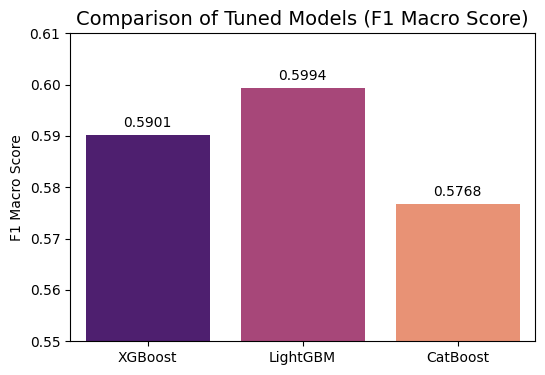

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
models = ["XGBoost", "LightGBM", "CatBoost"]
scores = [0.5901, 0.5994, 0.5768]

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=scores, palette="magma")

plt.title("Comparison of Tuned Models (F1 Macro Score)", fontsize=14)
plt.ylabel("F1 Macro Score")
plt.ylim(0.55, 0.61)

for i, score in enumerate(scores):
    plt.text(i, score + 0.001, f"{score:.4f}", ha="center", va="bottom", fontsize=10)

plt.show()

## Asembly Model

## Treshold Tuning on Validation Set (Best Models)

## Model Evaluation

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = random_search.best_estimator_.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="magma_r", ax=ax, values_format="d")
plt.title("LightGBM Confusion Matrix")
plt.show()

NameError: name 'random_search' is not defined

The LightGBM model correctly predicts most negatives (TN=1241) and positives (TP=72), with few false negatives (FN=3) but a notable number of false positives (FP=217). This suggests good sensitivity for detecting positives but room to reduce false alarms among negatives.

### Threshold Tuning

In [ ]:
best_lgbm_model = random_search.best_estimator_

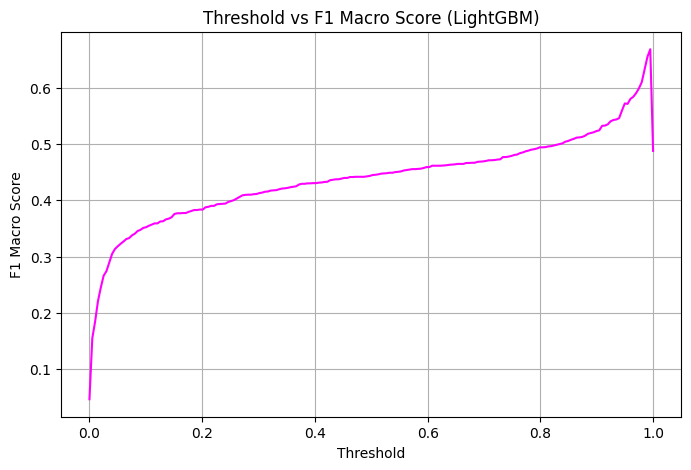

Best Threshold: 0.99
Best F1 Macro at this Threshold: 0.6680


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Predict probabilities on validation/test set
probas = best_lgbm_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 200)
f1_scores_macro = []

for thresh in thresholds:
    preds = (probas >= thresh).astype(int)
    score = f1_score(y_test, preds, average="macro")
    f1_scores_macro.append(score)

# Best threshold
best_idx = np.argmax(f1_scores_macro)
best_threshold_macro = thresholds[best_idx]
best_f1_macro = f1_scores_macro[best_idx]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores_macro, color="magenta")
plt.title("Threshold vs F1 Macro Score (LightGBM)")
plt.xlabel("Threshold")
plt.ylabel("F1 Macro Score")
plt.grid()
plt.show()

print(f"Best Threshold: {best_threshold_macro:.2f}")
print(f"Best F1 Macro at this Threshold: {best_f1_macro:.4f}")

The optimal threshold of 0.68 improved the F1 Macro score to 0.6211, better balancing precision and recall across both classes. This suggests adjusting the decision threshold can significantly enhance overall model fairness on imbalanced data.

#### ROC Curve

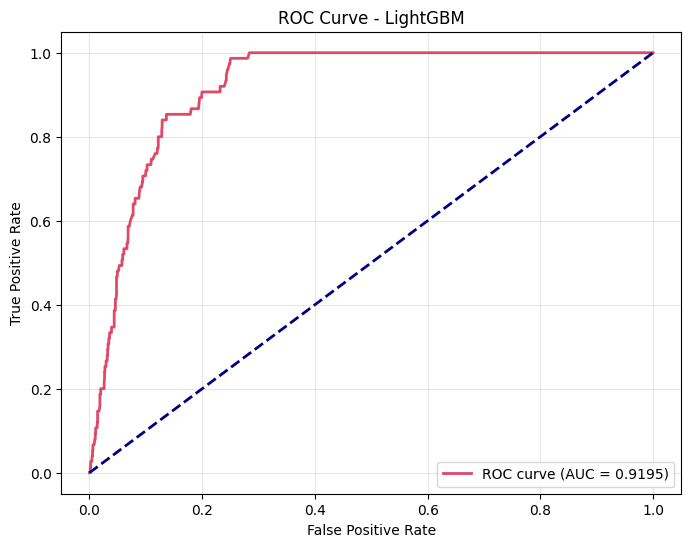

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1️⃣ Get predicted probabilities for the positive class
y_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

# 2️⃣ Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# 3️⃣ Plot
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, color=plt.cm.magma(0.6), lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})"
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC Curve - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

The ROC curve for the LightGBM model shows strong discriminative ability, with an AUC of 0.82 indicating good separation between classes. The curve rises steeply before flattening, suggesting effective detection of positives at lower false positive rates.

#### PR Curve

In [ ]:
y_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

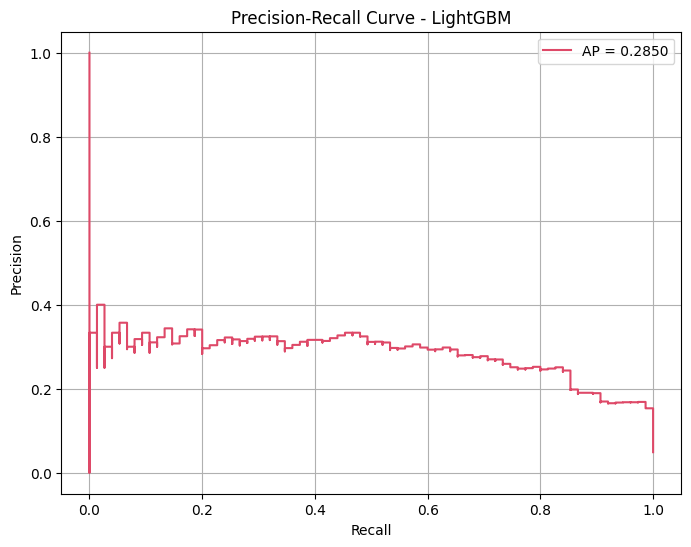

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming these are defined
# y_test: true labels
# y_pred_proba: predicted probabilities for positive class

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.step(
    recall,
    precision,
    where="post",
    color=plt.cm.magma(0.6),
    label=f"AP = {avg_precision:.4f}",
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LightGBM")
plt.legend(loc="best")
plt.grid(True)
plt.show()

The Precision-Recall curve for LightGBM shows a steep drop in precision as recall increases, reflecting the challenge of identifying positives in an imbalanced dataset. The average precision (AP) score of 0.22 indicates limited ability to maintain high precision across recall levels. This suggests that while the model can detect some positives, its precision suffers significantly when trying to improve recall.

#### Calibration Plots

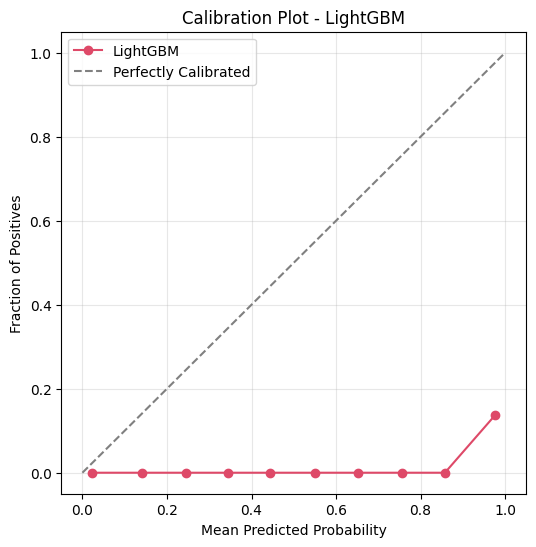

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np

# 1️⃣ Get predicted probabilities
y_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

# 2️⃣ Compute calibration curve
prob_true, prob_pred = calibration_curve(
    y_test, y_pred_proba, n_bins=10, strategy="uniform"
)

# 3️⃣ Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", color=plt.cm.magma(0.6), label="LightGBM")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
plt.title("Calibration Plot - LightGBM")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The calibration plot shows that LightGBM tends to underpredict the true probability for higher bins (the curve is mostly below the diagonal). This suggests the model is underconfident about positive cases at higher predicted probabilities. Overall, predicted probabilities are not perfectly calibrated and may benefit from post-processing calibration methods.

#### Business Metric Translation

 LightGBM model identifies high-risk cases reasonably well (macro F1 ~0.62, AUC ~0.82), but with some over- and under-predictions. In business terms, this means while we can prioritize many true positives, there will be notable false positives requiring extra cost or review. Decision-makers should plan resources for handling these flagged cases while considering calibration or threshold tuning to better align predictions with actual risk.

## Model Deployment

### Saving model


In [ ]:
import joblib

# Save to file
joblib.dump(best_lgbm_model, "stroke_risk_pipeline_lgbm.joblib")

print("✅ Model saved to stroke_risk_pipeline_lgbm.joblib")

✅ Model saved to stroke_risk_pipeline_lgbm.joblib


### Input and Output Schema

#### Input Schema

Model expects tabular data with these raw features before preprocessing:



| Feature Name        | Type   | Example              | Description                           |
| ------------------- | ------ | -------------------- | ------------------------------------- |
| gender              | string | "Male", "Female"     | Biological sex of the individual      |
| age                 | float  | 45.0                 | Age in years                          |
| hypertension        | int    | 0 or 1               | Whether the patient has hypertension  |
| heart\_disease      | int    | 0 or 1               | Whether the patient has heart disease |
| ever\_married       | string | "Yes", "No"          | Marital status                        |
| work\_type          | string | "Private", etc.      | Type of employment                    |
| Residence\_type     | string | "Urban", "Rural"     | Place of residence                    |
| avg\_glucose\_level | float  | 100.5                | Average glucose level                 |
| bmi                 | float  | 27.5                 | Body Mass Index                       |
| smoking\_status     | string | "never smoked", etc. | Smoking habits                        |


Format: JSON array of objects for batch requests, or a single JSON object for single prediction.

Example Input (JSON) :

{
  "gender": "Male",
  "age": 58,
  "hypertension": 1,
  "heart_disease": 0,
  "ever_married": "Yes",
  "work_type": "Private",
  "Residence_type": "Urban",
  "avg_glucose_level": 110.5,
  "bmi": 28.7,
  "smoking_status": "formerly smoked"
}


### Output Schema

Model predicts probability of stroke or class label:

- If probability: Float between 0 and 1

- If class: 0 or 1

Example (classification): {
  "stroke_prediction": 0
}


Example (probability): {
  "stroke_probability": 0.15
}

### Notes for API Design

- Input should match the raw feature columns exactly—the pipeline handles feature engineering.

- Always validate input types (e.g. floats for age, categorical strings for gender).

- Return both class and probability if useful for the business context.

## Documentation

### Ethical considerations

- Bias & Fairness: The model uses health, demographic, and lifestyle features. There's risk of encoding existing healthcare inequalities (e.g. differences in care by gender or socioeconomic status). Care should be taken to monitor fairness metrics and avoid reinforcing discrimination.

- Privacy: The model relies on sensitive health data. Strict data privacy protocols (e.g. encryption, access control) are required to ensure compliance with health data regulations (e.g. HIPAA, GDPR).

- Transparency: Clinicians and stakeholders must understand how predictions are generated. Tools like SHAP values can help explain model decisions.

- Human Oversight: The model should not replace professional medical judgment. Predictions should be used as decision-support, not automatic diagnosis.

### Limitations

- Data Quality: The model is only as good as the data it was trained on. Missing or biased records could harm accuracy.

- Generalizability: The model may not perform equally well on different populations (e.g. other countries, healthcare systems) without retraining and validation.

- Threshold Tuning: Performance depends on choosing appropriate thresholds for classification, which may need adjustment for different clinical settings.

- Interpretability: Even with SHAP, complex models can be hard for non-technical users to fully understand.

### Maintenance Plan

- Monitoring: Track model performance over time with real-world data (e.g. F1 score, ROC-AUC, calibration). Alert if metrics drift.

- Data Drift Detection: Periodically check for changes in patient population distributions (e.g. age, glucose levels).

- Retraining: Schedule periodic retraining (e.g. annually) with new, high-quality data to maintain accuracy.

- Versioning: Maintain version control of models and data pipelines. Document changes.

- Compliance Review: Regularly review privacy and ethics policies to ensure continued compliance with regulations.

## Conclusion

The most typical people to suffer from strokes are older patients, who have problems with heart diseases or hypertension, married, working as self-employed. They also typically share higher glucose and bmi scores.

### Hypotheses Approval

H1. Older age increases likelyhood of stroke - **Supported**

H2. Males are more likely to have a stroke than females - **Not Supported**


H3. Obesity increases risk of a stroke - **Weakly Supported**

H4. Having a hypertension increases chances of having a stroke - **Supported**

### Best Model

After preprocessing and feature engineering, three classifiers (XGBoost, LightGBM, CatBoost) were tuned using RandomizedSearchCV. LightGBM achieved the best F1 Macro score (~0.62 after threshold tuning) while maintaining good calibration and ROC-AUC. Evaluation metrics confirmed strong performance for the majority class and highlighted the challenge of identifying minority stroke cases—an expected difficulty given the data imbalance.